# Quantum Tic-Tac-Toe — A Quantum Challenger


### Project Overview

This notebook implements a **quantum version of Tic-Tac-Toe** using [Qiskit](https://qiskit.org), where each move places a marker in **superposition** across two squares. When markers form an **entanglement cycle**, a quantum measurement **collapses** the wave function, resolving all markers simultaneously.


### References

- [Nagy & Nagy (2012) — Quantum Tic-Tac-Toe: A Genuine Probabilistic Approach](https://academic.timwylie.com/17CSCI4341/quantum_tictactoe.pdf)
- [Jamil (2023) — Quantum Tic Tac Toe on IBM Quantum](https://physlab.org/wp-content/uploads/2023/05/QuantumTicTacToe_23100002_Fin.pdf)
- [Goff (2006) — Quantum Tic-Tac-Toe: A Teaching Metaphor](https://doi.org/10.1119/1.2213635)

### Structure

1. **Classical Tic-Tac-Toe** — Board, heuristic, Minimax alpha-beta
2. **Quantum Rules** — Bell states, 2q/9q circuits, cycle detection, collapse
3. **AI 1: Variational** — Parameterized circuit (2 qubits)
4. **AI 2: Grover** — Heuristic + quantum search (9 qubits)
5. **AI 3: QAOA + Grover** — QUBO evaluation + Grover
6. **AI 4: Minimax Quantum** — Probabilistic look-ahead
7. **Benchmarks** — AI vs Random (200 games) + Elo tournament

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
!pip install qiskit qiskit-aer

Length of the board 

In [5]:
N = 3

In [6]:
def initialization():
    board = [[0 for i in range(N)] for j in range(N)]
    return board

In [7]:
def display(board):
    n = len(board)
    
    fig, ax = plt.subplots()
    
    ax.set_facecolor('white')
    
    for i in range(n):
        ax.text(i, -0.5, str(i), ha='center', va='top')
    
    for j in range(n):
        ax.text(-0.5, j, str(j), ha='right', va='center')
    
    for i in range(n + 1):
        ax.axvline(x=i - 0.5, color='k', linewidth=1)
        ax.axhline(y=i - 0.5, color='k', linewidth=1)
    
    for i in range(n):
        for j in range(n):
            if board[i][j] == 1:
                ax.plot([j-0.3, j+0.3], [i-0.3, i+0.3], 'b-', linewidth=3)
                ax.plot([j-0.3, j+0.3], [i+0.3, i-0.3], 'b-', linewidth=3)
            elif board[i][j] == -1:
                circle = plt.Circle((j, i), 0.3, color='red', fill=False, linewidth=3)
                ax.add_patch(circle)
    
    ax.set_xlim(-0.5, n - 0.5)
    ax.set_ylim(-0.5, n - 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.show()

List of the possibilities on the board depending on each position 

In [13]:
def list_possibilities(board):
    L = []
    for i in range(N):
        for j in range(N):
            if board[i][j] == 0:
                L.append((i, j))
    return L

function which play

In [16]:
def make_move(x, y, board, player):
    new_board = deepcopy(board)
    new_board[x][y] = player
    return new_board

Check if the player 1 or 2 win 

In [19]:
def check_victory(board, player):
    for i in range(N):
        if all(board[i][j] == player for j in range(N)):
            return True
    
    for j in range(N):
        if all(board[i][j] == player for i in range(N)):
            return True
    
    if all(board[i][i] == player for i in range(N)):
        return True
    
    if all(board[i][N-1-i] == player for i in range(N)):
        return True
    
    return False

In [21]:
def determine_winner(board):
    if check_victory(board, 1):
        return "Player 1 has won"
    elif check_victory(board, -1):
        return "Player 2 has won"
    elif len(list_possibilities(board)) == 0:
        return "Draw"
    return None

# Heuristics in Two-Player Games
## Definition
A **heuristic** is a function that evaluates the quality of a game position without exploring all possibilities.
- **Score > 0**: favorable to Player 1 (X)
- **Score < 0**: favorable to Player 2 (O)
- **Score ≈ 0**: balanced position
Because it is impossible to explore all moves until the end (too many positions). We estimate the quality of a position with a fast function
## Our Heuristic for Tic-Tac-Toe
### Terminal Conditions
if victory(X): return +1000
if victory(O): return -1000
if draw: return 0
### Line Evaluation
Situation  Score 
2 X, 0 O Score +50 (threat for O) 
1 X, 0 O Score  +10 
0 X, 2 O Score  -50 (threat for X) 
0 X, 1 O Score  -10 
- **Center**: ±30 points
- **Corners**: ±20 points
## Example
  0   1   2
0 X | O |  
1   | X |  
2   |   |  
**Calculation**:
- Main diagonal (2 X, 0 O): +50
- Center (X): +30
- Corner (0,0) with X: +20
- Rows/columns with 1 X: 2×10 = +20
**Total score = +120** → Position strongly favorable to X
## Role in Minimax
The heuristic **guides the AI's decisions**:
- Player 1 seeks to **maximize** h(board)
- Player 2 seeks to **minimize** h(board)

In [24]:
def heuristic(board):
    winner = determine_winner(board)
    
    if winner == "Player 1 has won":
        return 1000
    elif winner == "Player 2 has won":
        return -1000
    elif winner == "Draw":
        return 0
    
    score = 0
    lines = []
    
    for i in range(N):
        lines.append([board[i][j] for j in range(N)])
    
    for j in range(N):
        lines.append([board[i][j] for i in range(N)])
    
    lines.append([board[i][i] for i in range(N)])
    lines.append([board[i][N-1-i] for i in range(N)])
    
    for line in lines:
        x_count = line.count(1)
        o_count = line.count(-1)
        
        if o_count == 0:
            if x_count == 2:
                score += 50
            elif x_count == 1:
                score += 10
        
        if x_count == 0:
            if o_count == 2:
                score -= 50
            elif o_count == 1:
                score -= 10
    
    if board[1][1] == 1:
        score += 30
    elif board[1][1] == -1:
        score -= 30
    
    corners = [(0, 0), (0, 2), (2, 0), (2, 2)]
    for i, j in corners:
        if board[i][j] == 1:
            score += 20
        elif board[i][j] == -1:
            score -= 20
    
    return score

In [26]:
def optimal_heuristic(board):
    winner = determine_winner(board)
    
    if winner == "Player 1 has won":
        return 10000
    elif winner == "Player 2 has won":
        return -10000
    elif winner == "Draw":
        return 0
    
    score = 0
    
    lines = []
    for i in range(N):
        lines.append([board[i][j] for j in range(N)])
    for j in range(N):
        lines.append([board[i][j] for i in range(N)])
    lines.append([board[i][i] for i in range(N)])
    lines.append([board[i][N-1-i] for i in range(N)])
    
    threats_x = 0
    threats_o = 0
    
    for line in lines:
        x_count = line.count(1)
        o_count = line.count(-1)
        empties = line.count(0)
        
        if x_count == 2 and o_count == 0:
            score += 100
            threats_x += 1
        elif x_count == 1 and o_count == 0 and empties == 2:
            score += 10
        
        if o_count == 2 and x_count == 0:
            score -= 100
            threats_o += 1
        elif o_count == 1 and x_count == 0 and empties == 2:
            score -= 10
    
    if threats_x >= 2:
        score += 500
    if threats_o >= 2:
        score -= 500
    
    if board[1][1] == 1:
        score += 40
    elif board[1][1] == -1:
        score -= 40
    
    corners = [(0, 0), (0, 2), (2, 0), (2, 2)]
    corners_x = sum(1 for i, j in corners if board[i][j] == 1)
    corners_o = sum(1 for i, j in corners if board[i][j] == -1)
    
    if corners_x >= 2:
        score += 50
    elif corners_x == 1:
        score += 30
    
    if corners_o >= 2:
        score -= 50
    elif corners_o == 1:
        score -= 30
    
    main_diag = [board[i][i] for i in range(N)]
    secondary_diag = [board[i][N-1-i] for i in range(N)]
    
    for diag in [main_diag, secondary_diag]:
        if diag.count(1) >= 1 and diag.count(-1) == 0:
            score += 20
        if diag.count(-1) >= 1 and diag.count(1) == 0:
            score -= 20
    
    return score

# Minimax with Alpha-Beta Pruning
## Minimax: Basic Principle
Algorithm to find the **best move** in a two-player game.
**Idea**: Simulate all possible moves and choose the best one.
- **Max Player (X)**: seeks to maximize the score
- **Min Player (O)**: seeks to minimize the score
Each player assumes the opponent plays perfectly.
## Problem
For tic-tac-toe: ~255,000 positions to evaluate → slow
## Alpha-Beta Pruning
**Idea**: Stop exploring a branch if we already know it cannot be better.
### Variables
- **α (alpha)**: best guaranteed score for Max (start: -∞)
- **β (beta)**: best guaranteed score for Min (start: +∞)
Without pruning: ~255,000 nodes
With pruning: ~2,000 nodes
**Same result, much faster computation**

In [29]:
def minimax_alphabeta_pruning(board, max_depth, player):
    
    def score(board, depth, current_player, alpha, beta):
        opponent = -current_player
        winner = determine_winner(board)
        
        if depth == max_depth or winner is not None:
            return optimal_heuristic(board)
        
        possible_moves = list_possibilities(board)
        
        if current_player == 1:
            max_score = float('-inf')
            best_move = None
            
            for i, j in possible_moves:
                new_board = make_move(i, j, board, current_player)
                move_score = score(new_board, depth + 1, opponent, alpha, beta)
                
                if move_score > max_score:
                    max_score = move_score
                    best_move = (i, j)
                
                alpha = max(alpha, max_score)
                if beta <= alpha:
                    break
            
            if depth == 0:
                return max_score, best_move
            return max_score
        
        else:
            min_score = float('inf')
            best_move = None
            
            for i, j in possible_moves:
                new_board = make_move(i, j, board, current_player)
                move_score = score(new_board, depth + 1, opponent, alpha, beta)
                
                if move_score < min_score:
                    min_score = move_score
                    best_move = (i, j)
                
                beta = min(beta, min_score)
                if beta <= alpha:
                    break
            
            if depth == 0:
                return min_score, best_move
            return min_score
    
    alpha = float("-inf")
    beta = float("inf")
    return score(board, 0, player, alpha, beta)

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


ligne: 0
colonne: 0


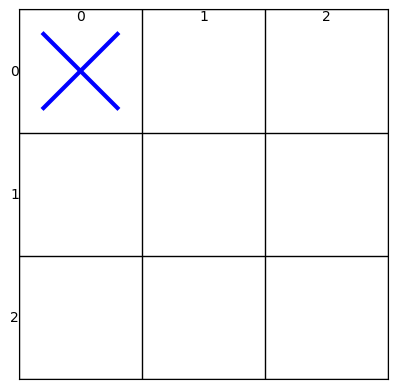

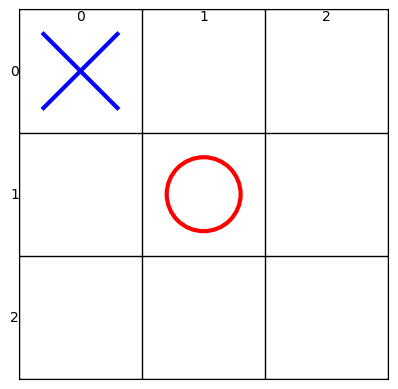

[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1), (2, 2)]


ligne: 0
colonne: 1


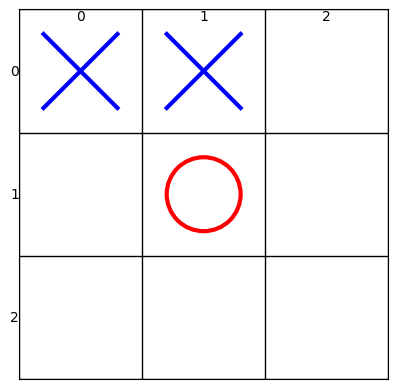

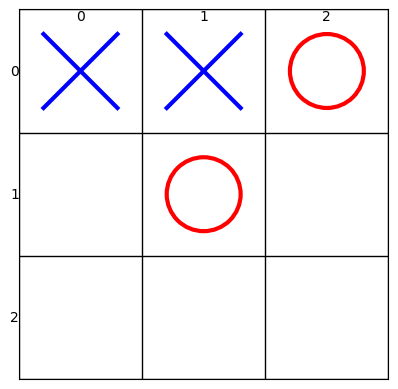

[(1, 0), (1, 2), (2, 0), (2, 1), (2, 2)]


ligne: 10
colonne: 1


pas possible


ligne: 1
colonne: 0


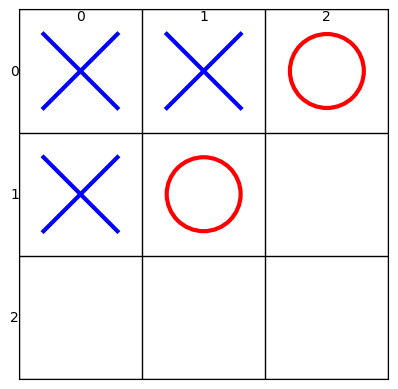

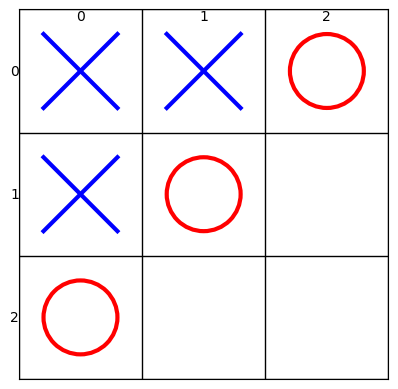

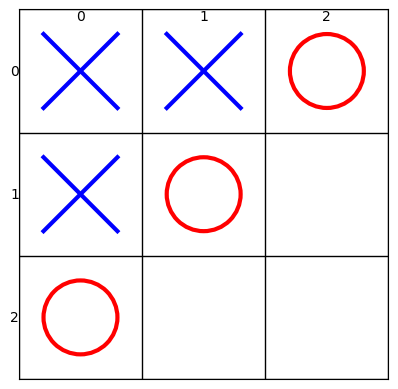

Le joueur 2 a gagné


'Le joueur 2 a gagné'

In [31]:
def joue_premier_coup(plateau, joueur):
    L = liste_possibilite(plateau)
    if L == []:
        return None
    
    print(L)
    
    while True:
        try:
            x = int(input("ligne:"))
            y = int(input("colonne:"))
            if (x, y) in L:
                return retournement(x, y, plateau, joueur)
            else:
                print("pas possible")
        except ValueError:
            print("pas possible")

def joue_partie():
    plateau = initialisation()
    joueur1 = 1
    joueur2 = -1
    
    while True:
        gagnant = determine_gagnant(plateau)
        if gagnant is not None:
            affichage(plateau)
            print(gagnant)
            return gagnant
        
        nouveau_plateau = joue_premier_coup(plateau, joueur1)
        if nouveau_plateau is None:
            affichage(plateau)
            print("Match nul")
            return "Match nul"
        plateau = nouveau_plateau
        affichage(plateau)
        
        gagnant = determine_gagnant(plateau)
        if gagnant is not None:
            print(gagnant)
            return gagnant
        
        score, coup = minmax_elagage_alphabeta(plateau, 9, joueur2)
        if coup:
            x, y = coup
            plateau = retournement(x, y, plateau, joueur2)
            affichage(plateau)

joue_partie()

## Quantum tic tac toe

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from scipy.optimize import minimize
import time
import networkx as nx
import random
import math



N = 3

We will start by using the same architecture, but initializing an empty list of quantum markers. The game board will be modular so that we can try different board sizes. Additionally, when a cell is empty it will be initialized to 0, when we choose X it will be 1, and -1 will be associated with O. The quantum markers will be organized as follows: [(player, square1, square2, number), ...]

In [35]:
def init_quantum():
    board = [[0 for i in range(N)] for j in range(N)]
    marks_q = []
    return board, marks_q

Just like in the classical case, we need a function that will display the available squares to play, returned as tuples. Even if a square has unmeasured quantum markers, it remains "available". This is what we want. Multiple quantum markers can overlap in superposition.

In [37]:
def available_cells_quantum(board, marks_q):
    cells = []
    for i in range(N):
        for j in range(N):
            if board[i][j] == 0:
                cells.append((i, j))
    return cells

The goal here is to place a quantum marker in superposition on 2 squares, but since we haven't performed any measurement yet, we don't actually modify the board. The number here serves to mark the move that was just played, to know if it was the first move, the second, etc...

In [42]:
def play_quantum_move(board, marks_q, player, cell1, cell2):
    number = len(marks_q) + 1
    marks_q.append((player, cell1, cell2, number))
    return board, marks_q

Now that we have initialized a game board, we need to know when to perform the measurement on the board. Several solutions exist, the first is to detect cycles, for example: X1-O2, O2-X3, X3-X1. So from there we perform a measurement that will return to the classical state. The second solution is to place all moves in superposition until the board is full, and once it is full we perform the measurement (this one is based on a professor from UTS in Sydney). We chose the first one because it seems more relevant and more conducive to strategy.

### Cycle Detection
- Step 1: If fewer than 2 markers, impossible to have a cycle -> immediate return
- Step 2: Create a dictionary that says "which markers touch which square"
- Step 3: Go through each square. If a square has 2 or more markers -> CYCLE DETECTED
- Step 4: Initialize a breadth-first search (BFS)
    - visited_markers: markers already visited
    - queue: markers to explore
    - cycle_squares: squares involved in the cycle
- Step 5: BFS traversal (Breadth-First Search)
- Step 6: Return the result
If cycle found: (True, [marker indices], [cycle squares])
Otherwise: (False, None, None)

In [46]:
def detect_cycle_entanglement(marks_q):
    if len(marks_q) < 3:  # Minimum 3 marks for a cycle
        return False, None, None
    
    # Build graph: cell -> list of mark indices
    cell_to_marks = {}
    
    for idx, (player, (i1, j1), (i2, j2), num) in enumerate(marks_q):
        cell1 = (i1, j1)
        cell2 = (i2, j2)
        
        if cell1 not in cell_to_marks:
            cell_to_marks[cell1] = []
        if cell2 not in cell_to_marks:
            cell_to_marks[cell2] = []
        
        cell_to_marks[cell1].append(idx)
        cell_to_marks[cell2].append(idx)
    
    # Build a graph of connected marks
    mark_to_marks = {}  # mark -> list of neighboring marks
    for idx in range(len(marks_q)):
        mark_to_marks[idx] = set()
    
    for cell, mark_indices in cell_to_marks.items():
        if len(mark_indices) >= 2:
            # Connect all marks that share this cell
            for i in range(len(mark_indices)):
                for j in range(i+1, len(mark_indices)):
                    mark_to_marks[mark_indices[i]].add(mark_indices[j])
                    mark_to_marks[mark_indices[j]].add(mark_indices[i])
    
    # Detect a cycle with DFS
    def find_cycle_dfs(node, parent, visited, path):
        visited.add(node)
        path.append(node)
        
        for neighbor in mark_to_marks[node]:
            if neighbor not in visited:
                result = find_cycle_dfs(neighbor, node, visited, path)
                if result is not None:
                    return result
            elif neighbor != parent and neighbor in path:
                # Cycle detected! Extract the cycle
                cycle_start_idx = path.index(neighbor)
                return path[cycle_start_idx:]
        
        path.pop()
        return None
    
    # Search for a cycle starting from each unvisited mark
    global_visited = set()
    
    for idx in range(len(marks_q)):
        if idx not in global_visited:
            path = []
            cycle = find_cycle_dfs(idx, -1, global_visited, path)
            
            if cycle is not None:
                # Cycle found! Collect the cells of the cycle
                cycle_cells = set()
                for m_idx in cycle:
                    player, (i1, j1), (i2, j2), num = marks_q[m_idx]
                    cycle_cells.add((i1, j1))
                    cycle_cells.add((i2, j2))
                
                return True, cycle, list(cycle_cells)
    
    # No cycle found
    return False, None, None

### Quantum Measurement

Initially, we implement a 2-qubit circuit formalized as a Bell state to guarantee |01⟩ or |10⟩ (never |00⟩ or |11⟩).

Why this circuit?
In quantum tic-tac-toe, a mark is on ONE of the 2 cells, never both, never none.

|01⟩ → cell 2 occupied, cell 1 empty;
|10⟩ → cell 1 occupied, cell 2 empty

- The Hadamard gate is used to create equal superposition of |0⟩ and |1⟩ in all the tiles at the beginning of the game
- CNOT gate will be used to create entanglement with two states, such that they form two bell states (explained in more detail ahead).

In [49]:
def creer_circuit_bell_state():
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.x(1)
    return qc

The purpose of measurement_collapse is therefore to execute a circuit that we give it and have it return the bitstring: '01' or '10'. We will therefore use qiskit to create a quantum simulator.

In [52]:
def measurement_collapse(qc):
    
    # Measure qubits 0 and 1
    # Store results in classical bits 0 and 1
    qc.measure([0, 1], [0, 1])
    # Simulate a real quantum computer
    simulator = AerSimulator()
    compiled = transpile(qc, simulator)
    job = simulator.run(compiled, shots=1)
    result = job.result()
    counts = result.get_counts()
    return list(counts.keys())[0]

Maintenant on va mesure uniquement les marques du cycle et les autres marques restent en superposition.

- Step 1: Initialize with occupied cells and new quantum marks that have been placed (not measured ones)
- Step 2: If index is in cycle_marks_indices measure, otherwise keep in superposition
- Step 3: Create and measure circuit

        - create_circuit_bell_state() → circuit that gives |01⟩ or |10⟩
        - measurement_collapse(qc) → execute and obtain '01' or '10'
- Step 4: If we get 01 we know we will be on cell 2 and if we get 10 we know we will be on cell 1
- Step 5: Place the mark on the classical board, verify the cell is not already occupied, then modify the board, and add this cell to avoid duplicates
- Step 6: We will still keep marks outside the cycle since they remain quantum (not measured), they will just be measured later (in another cycle or at the end of the game)

In [56]:
def measure_cycle(board, marks_q, cycle_marks_indices):
    occupied_cells = set()
    new_marks_q = []

    for i in range(N):
        for j in range(N):
            if board[i][j] != 0:
                occupied_cells.add((i, j))

    #print(f"\n CYCLE MEASUREMENT ({len(cycle_marks_indices)} marks)")

    # Single draw for the entire cycle
    qc = create_circuit_bell_state()
    result = measurement_collapse(qc)

    for idx, mark in enumerate(marks_q):
        if idx in cycle_marks_indices:
            player, (i1, j1), (i2, j2), num = mark

            if result == '10':
                preferred_cell, alt_cell = (i1, j1), (i2, j2)
            else:
                preferred_cell, alt_cell = (i2, j2), (i1, j1)

            if preferred_cell not in occupied_cells and board[preferred_cell[0]][preferred_cell[1]] == 0:
                final_cell = preferred_cell
            elif alt_cell not in occupied_cells and board[alt_cell[0]][alt_cell[1]] == 0:
                final_cell = alt_cell
            else:
                final_cell = None

            if final_cell:
                board[final_cell[0]][final_cell[1]] = player
                occupied_cells.add(final_cell)
                symbol = 'X' if player == 1 else 'O'
                print(f"  {symbol}{num} → {final_cell}")
        else:
            new_marks_q.append(mark)

    return board, new_marks_q

And if no other cycles were detected before the end of the game, we must measure the final state.

In [59]:
def collapse_quantum_v1(board, marks_q):
    #print(f"\n FINAL MEASUREMENT: {len(marks_q)} marks")

    occupied_cells = set()
    for i in range(N):
        for j in range(N):
            if board[i][j] != 0:
                occupied_cells.add((i, j))

    for player, (i1, j1), (i2, j2), num in marks_q:
        qc = create_circuit_bell_state()
        result = measurement_collapse(qc)

        if result == '10':
            preferred_cell, alt_cell = (i1, j1), (i2, j2)
        else:
            preferred_cell, alt_cell = (i2, j2), (i1, j1)

        if preferred_cell not in occupied_cells and board[preferred_cell[0]][preferred_cell[1]] == 0:
            final_cell = preferred_cell
        elif alt_cell not in occupied_cells and board[alt_cell[0]][alt_cell[1]] == 0:
            final_cell = alt_cell
        else:
            final_cell = None

        if final_cell:
            board[final_cell[0]][final_cell[1]] = player
            occupied_cells.add(final_cell)
            symbol = 'X' if player == 1 else 'O'
            print(f"  {symbol}{num} → {final_cell}")

    return board, []

# 4. DISPLAY

Display the board with classical and quantum marks.

In [63]:
def quantum_display(board, marks_q):
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-0.5, N - 0.5)
    ax.set_ylim(-0.5, N - 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    
    # Grid
    for i in range(N + 1):
        ax.axvline(x=i - 0.5, color='black', linewidth=2)
        ax.axhline(y=i - 0.5, color='black', linewidth=2)
    
    # Classical marks (after collapse)
    for i in range(N):
        for j in range(N):
            if board[i][j] == 1:  # Classical X
                ax.plot([j-0.3, j+0.3], [i-0.3, i+0.3], 'b-', linewidth=4)
                ax.plot([j-0.3, j+0.3], [i+0.3, i-0.3], 'b-', linewidth=4)
            elif board[i][j] == -1:  # Classical O
                circle = plt.Circle((j, i), 0.3, color='red', fill=False, linewidth=4)
                ax.add_patch(circle)
    
    # Quantum marks (in superposition)
    for player, (i1, j1), (i2, j2), num in marks_q:
        color = 'blue' if player == 1 else 'red'
        symbol = 'X' if player == 1 else 'O'
        
        # Display on both cells
        ax.text(j1+0.2, i1-0.2, f'{symbol}{num}', 
                fontsize=9, color=color, alpha=0.6, fontweight='bold')
        ax.text(j2+0.2, i2-0.2, f'{symbol}{num}', 
                fontsize=9, color=color, alpha=0.6, fontweight='bold')
        
        # Dotted line between the two cells
        ax.plot([j1+0.5, j2+0.5], [i1+0.5, i2+0.5], 
                color=color, linestyle='--', linewidth=1, alpha=0.4)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Quantum Tic-Tac-Toe', fontsize=14, fontweight='bold')
    plt.show()

# 6. QUANTUM AI PARAMETERIZED CIRCUIT

In [66]:
N_PARAMS = 4  # Just 4 parameters: RY and RZ for 2 qubits

Simple quantum circuit: 2 qubits, 2 rotations each, 1 CNOT.
Encodes cell state (empty or occupied)
Applies rotations with theta (AI "thinks" with these angles)
Applies CNOT to link the 2 qubits (entanglement)
Measures to obtain a result

In [69]:
def ai_circuit(cell1_empty, cell2_empty, theta):
    qc = QuantumCircuit(2, 2)
    # If cell occupied, flip qubit to |1⟩
    if not cell1_empty:
        qc.x(0)
    if not cell2_empty:
        qc.x(1)
    
    # Rotations with theta
    qc.ry(theta[0], 0)
    qc.rz(theta[1], 0)
    qc.ry(theta[2], 1)
    qc.rz(theta[3], 1)
    # Entanglement
    qc.cx(0, 1)
    qc.measure_all()
    return qc

We will then evaluate the pairs, their role is to give a score between 0 and 1 for a pair of cells.
Why:
Executes the circuit 100 times (probabilistic results)
Counts how many '1's in the results
More '1's = better score = good pair

In [72]:
def evaluate_pair(board, cell1, cell2, theta):
    # Create circuit
    c1_empty = (board[cell1[0]][cell1[1]] == 0)
    c2_empty = (board[cell2[0]][cell2[1]] == 0)
    qc = ai_circuit(c1_empty, c2_empty, theta)
    
    # Execute 100 times
    simulator = AerSimulator()
    job = simulator.run(transpile(qc, simulator), shots=100)
    counts = job.result().get_counts()
    
    # Count how many '1's
    score = 0
    for bitstring, count in counts.items():
        nb_ones = bitstring.count('1')
        score += nb_ones * count
    
    return score / 200  # Normalize (max = 2 qubits × 100 shots = 200)

Now after evaluating the cell pairs, we will retrieve for example 10 random cell pairs that it has evaluated, or all if it can, and will then choose the best one

In [75]:
def choose_ai_move(board, marks_q, theta):

    cells = available_cells_quantum(board, marks_q)
    
    if len(cells) < 2:
        return None, None
    
    # If many cells, take just 10 random pairs
    if len(cells) > 5:
        pairs_to_test = []
        for _ in range(10):
            c1, c2 = random.sample(cells, 2)
            pairs_to_test.append((c1, c2))
    else:
        # Otherwise test all pairs
        pairs_to_test = []
        for i in range(len(cells)):
            for j in range(i+1, len(cells)):
                pairs_to_test.append((cells[i], cells[j]))
    
    # Evaluate each pair
    best_score = -1
    best_pair = (None, None)
    
    for c1, c2 in pairs_to_test:
        score = evaluate_pair(board, c1, c2, theta)
        if score > best_score:
            best_score = score
            best_pair = (c1, c2)
    
    return best_pair

We therefore need to train the AI, we have just seen that we use Y and Z rotation gates, so we need to evaluate theta and see which theta makes it win most often.

In [79]:
def train_ai(n_games=10):
    
    def play_game(theta):
        board, marks_q = init_quantum()
        
        for turn in range(10):
            # AI plays
            c1, c2 = choose_ai_move(board, marks_q, theta)
            if c1 is None:
                break
            board, marks_q = play_quantum_move(board, marks_q, -1, c1, c2)
            
            # Check cycle (YOUR FUNCTION)
            cycle_detected, cycle_marks, cycle_cells = detect_cycle_entanglement(marks_q)
            if cycle_detected:
                board, marks_q = measure_cycle(board, marks_q, cycle_marks)
            
            if check_victory(board, -1):
                return 1
            
            # Random plays
            cells = available_cells_quantum(board, marks_q)
            if len(cells) < 2:
                break
            c1, c2 = random.sample(cells, 2)
            board, marks_q = play_quantum_move(board, marks_q, 1, c1, c2)
            
            cycle_detected, cycle_marks, cycle_cells = detect_cycle_entanglement(marks_q)
            if cycle_detected:
                board, marks_q = measure_cycle(board, marks_q, cycle_marks)
            
            if check_victory(board, 1):
                return -1
            
            turn += 1
        
        return 0
    
    def evaluate(theta):
        total_score = 0
        for _ in range(n_games):
            total_score += play_game(theta)
        return -total_score
    
    print(f"Training on {n_games} games")
    theta_init = np.random.uniform(-np.pi, np.pi, N_PARAMS)
    result = minimize(evaluate, theta_init, method='COBYLA', options={'maxiter': 20})
    
    print(f"Completed! Score: {-result.fun}")
    return result.x


def save(theta):
    np.save('ai_theta.npy', theta)
    print("Saved")

def load():
    return np.load('ai_theta.npy')

In [214]:
def play_complete_game(theta):
    print("QUANTUM TIC-TAC-TOE")
    
    # Choose who starts
    while True:
        choice = input("\nWho starts? (1=You, 2=AI) : ")
        if choice in ['1', '2']:
            break
    
    human_starts = (choice == '1')
    
    # Initialize
    board, marks_q = init_quantum()
    turn = 0
    
    print("\n📋 You play X, AI plays O\n")
    
    while turn < 10:
        print(f"\n{'='*60}")
        print(f"TURN {turn + 1}")
        print(f"{'='*60}")
        
        # Determine who plays
        if (human_starts and turn % 2 == 0) or (not human_starts and turn % 2 == 1):
            # HUMAN TURN
            print("\nYOUR TURN")
            
            # Use YOUR available_cells_quantum function
            cells = available_cells_quantum(board, marks_q)
            if len(cells) < 2:
                break
            
            # Display with YOUR function
            quantum_display(board, marks_q)
            
            print(f"\nAvailable cells : {cells}")
            
            # Input
            while True:
                try:
                    i1 = int(input("Mark 1 - row (0-2) : "))
                    j1 = int(input("Mark 1 - column (0-2) : "))
                    i2 = int(input("Mark 2 - row (0-2) : "))
                    j2 = int(input("Mark 2 - column (0-2) : "))
                    
                    if (i1,j1) in cells and (i2,j2) in cells and (i1,j1) != (i2,j2):
                        break
                    print("Invalid")
                except:
                    print("Error")
            
            # Play with YOUR function
            board, marks_q = play_quantum_move(board, marks_q, 1, (i1,j1), (i2,j2))
            print(f"You play : {(i1,j1)} and {(i2,j2)}")
            
        else:
            # AI TURN
            print("\nAI TURN")
            print("Thinking", end='', flush=True)
            
            # AI chooses with our simplified function
            cell1, cell2 = choose_ai_move(board, marks_q, theta)
            
            if cell1 is None:
                break
            
            # Play with YOUR function
            board, marks_q = play_quantum_move(board, marks_q, -1, cell1, cell2)
            print(f"\rAI plays : {cell1} and {cell2}")
        
        # Check cycle with YOUR detect_cycle_entanglement function
        cycle_detected, cycle_marks, cycle_cells = detect_cycle_entanglement(marks_q)
        if cycle_detected:
            print(f"\nCYCLE ! Cells : {cycle_cells}")
            # Measure with YOUR measure_cycle function
            board, marks_q = measure_cycle(board, marks_q, cycle_marks)
            quantum_display(board, marks_q)
        
        # Check victory with YOUR function
        if check_victory(board, 1):
            print("\nYOU WON !")
            quantum_display(board, marks_q)
            return
        
        if check_victory(board, -1):
            print("\nAI WON !")
            quantum_display(board, marks_q)
            return
        
        turn += 1
    
    # Final measurement with YOUR function
    if marks_q:
        print("\nFinal measurement...")
        board, marks_q = collapse_quantum_v1(board, marks_q)
    if check_victory(board, 1):
        print("YOU WON !")
    elif check_victory(board, -1):
        print("AI WON !")
    else:
        print("DRAW !")
    quantum_display(board, marks_q)

# Test

🎓 Entraînement sur 2 parties...

 MESURE DU CYCLE (3 marques)
  O3 → (1, 2)
  X4 → (2, 1)
  O5 → (2, 2)

 MESURE DU CYCLE (3 marques)
  O1 → (0, 2)
  X2 → (2, 0)

 MESURE DU CYCLE (3 marques)
  X2 → (2, 2)
  O7 → (1, 1)

 MESURE DU CYCLE (3 marques)
  O3 → (0, 0)
  X5 → (2, 0)
  O6 → (2, 1)

 MESURE DU CYCLE (3 marques)
  O1 → (0, 2)

 MESURE DU CYCLE (3 marques)
  X4 → (1, 0)
  X3 → (1, 2)

 MESURE DU CYCLE (3 marques)
  X2 → (0, 2)
  O3 → (1, 2)
  X4 → (2, 2)

 MESURE DU CYCLE (3 marques)
  O1 → (0, 0)

 MESURE DU CYCLE (3 marques)
  O1 → (1, 1)
  X2 → (2, 1)

 MESURE DU CYCLE (3 marques)
  X1 → (2, 0)
  O2 → (1, 0)

 MESURE DU CYCLE (3 marques)
  O1 → (0, 2)
  X2 → (0, 1)

 MESURE DU CYCLE (3 marques)
  X4 → (0, 0)

 MESURE DU CYCLE (3 marques)
  O3 → (2, 1)
  X4 → (1, 2)

 MESURE DU CYCLE (3 marques)
  X6 → (1, 0)
  O4 → (1, 1)

 MESURE DU CYCLE (3 marques)
  X3 → (2, 2)

 MESURE DU CYCLE (3 marques)
  X2 → (0, 2)

 MESURE DU CYCLE (3 marques)
  O1 → (1, 0)

 MESURE DU CYCLE (4 mar


Qui commence ? (1=Vous, 2=IA) :  1



📋 Vous jouez X, l'IA joue O


TOUR 1

👤 VOTRE TOUR


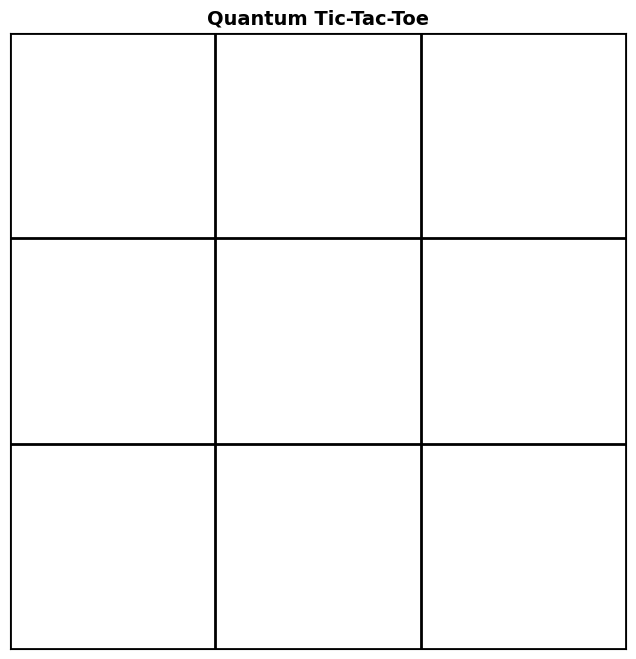


Cases disponibles : [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


Marque 1 - ligne (0-2) :  0
Marque 1 - colonne (0-2) :  0
Marque 2 - ligne (0-2) :  0
Marque 2 - colonne (0-2) :  1


✅ Vous jouez : (0, 0) et (0, 1)

TOUR 2

🤖 TOUR IA
✅ IA joue : (0, 0) et (2, 2)

TOUR 3

👤 VOTRE TOUR


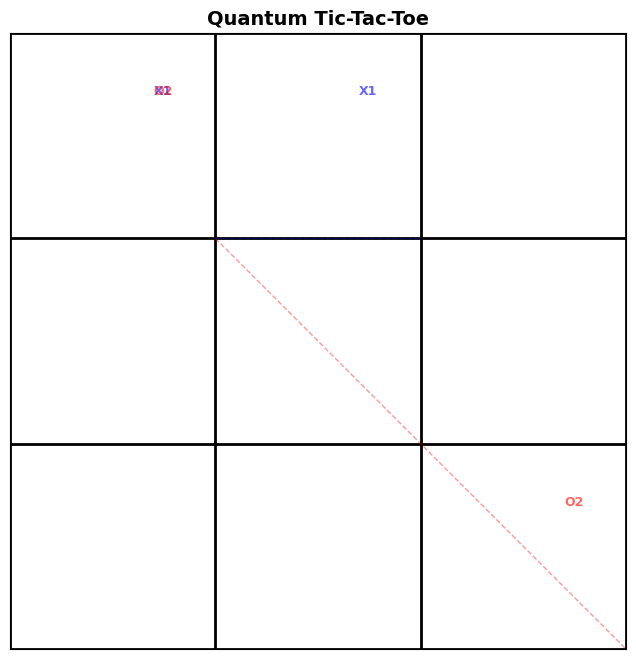


Cases disponibles : [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


Marque 1 - ligne (0-2) :  2
Marque 1 - colonne (0-2) :  2
Marque 2 - ligne (0-2) :  0
Marque 2 - colonne (0-2) :  1


✅ Vous jouez : (2, 2) et (0, 1)

🔴 CYCLE ! Cases : [(0, 1), (2, 2), (0, 0)]

 MESURE DU CYCLE (3 marques)
  X1 → (0, 1)
  O2 → (2, 2)


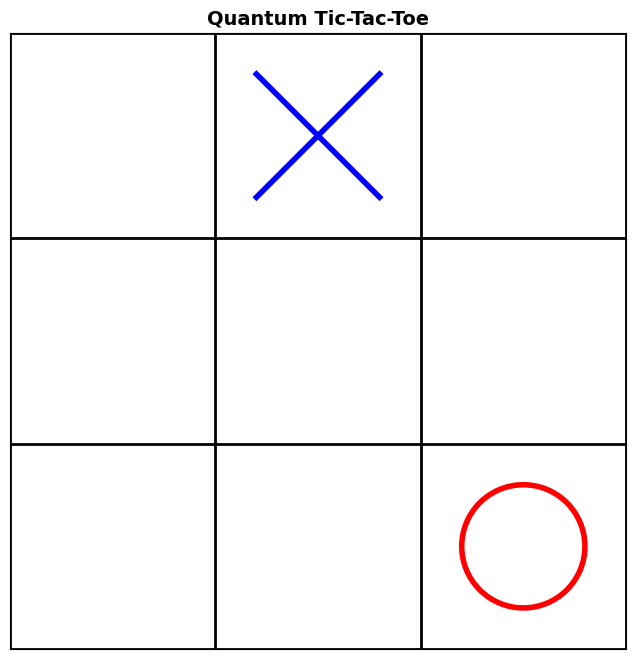


TOUR 4

🤖 TOUR IA
✅ IA joue : (1, 0) et (0, 0)

TOUR 5

👤 VOTRE TOUR


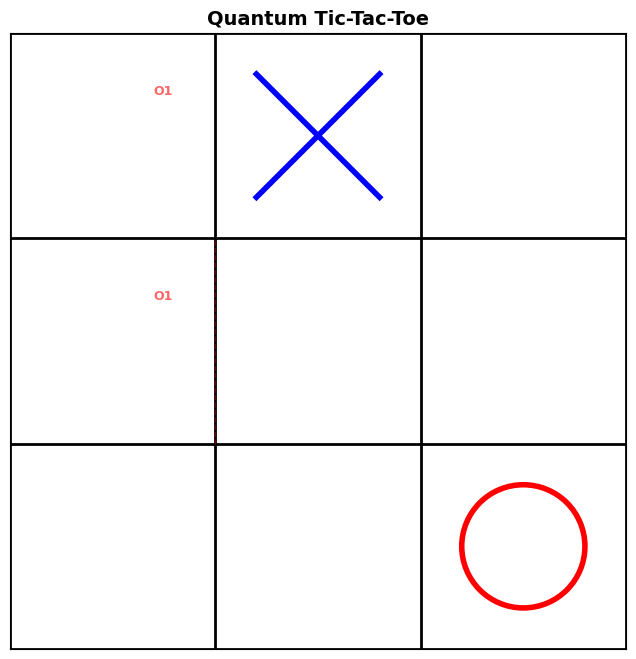


Cases disponibles : [(0, 0), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1)]


Marque 1 - ligne (0-2) :  0
Marque 1 - colonne (0-2) :  0
Marque 2 - ligne (0-2) :  0
Marque 2 - colonne (0-2) :  2


✅ Vous jouez : (0, 0) et (0, 2)

TOUR 6

🤖 TOUR IA
✅ IA joue : (0, 2) et (0, 0)

🔴 CYCLE ! Cases : [(1, 0), (0, 2), (0, 0)]

 MESURE DU CYCLE (3 marques)
  O1 → (0, 0)
  O3 → (0, 2)


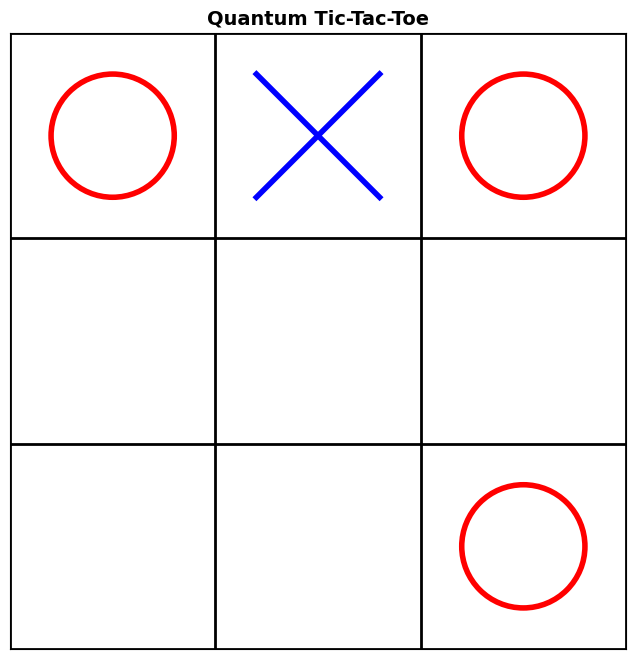


TOUR 7

👤 VOTRE TOUR


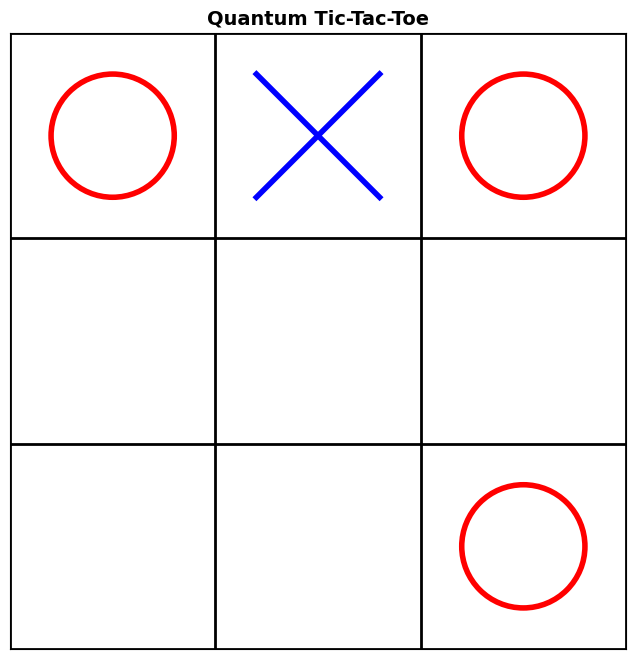


Cases disponibles : [(1, 0), (1, 1), (1, 2), (2, 0), (2, 1)]


Marque 1 - ligne (0-2) :  1
Marque 1 - colonne (0-2) :  1
Marque 2 - ligne (0-2) :  2
Marque 2 - colonne (0-2) :  1


✅ Vous jouez : (1, 1) et (2, 1)

TOUR 8

🤖 TOUR IA
✅ IA joue : (1, 0) et (1, 1)

TOUR 9

👤 VOTRE TOUR


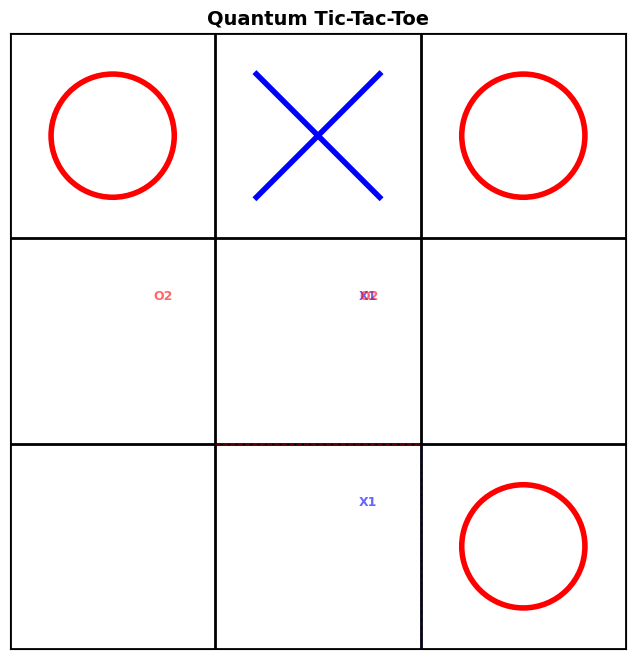


Cases disponibles : [(1, 0), (1, 1), (1, 2), (2, 0), (2, 1)]


Marque 1 - ligne (0-2) :  1
Marque 1 - colonne (0-2) :  1
Marque 2 - ligne (0-2) :  2
Marque 2 - colonne (0-2) :  1


✅ Vous jouez : (1, 1) et (2, 1)

🔴 CYCLE ! Cases : [(1, 0), (1, 1), (2, 1)]

 MESURE DU CYCLE (3 marques)
  X1 → (2, 1)
  O2 → (1, 0)
  X3 → (1, 1)


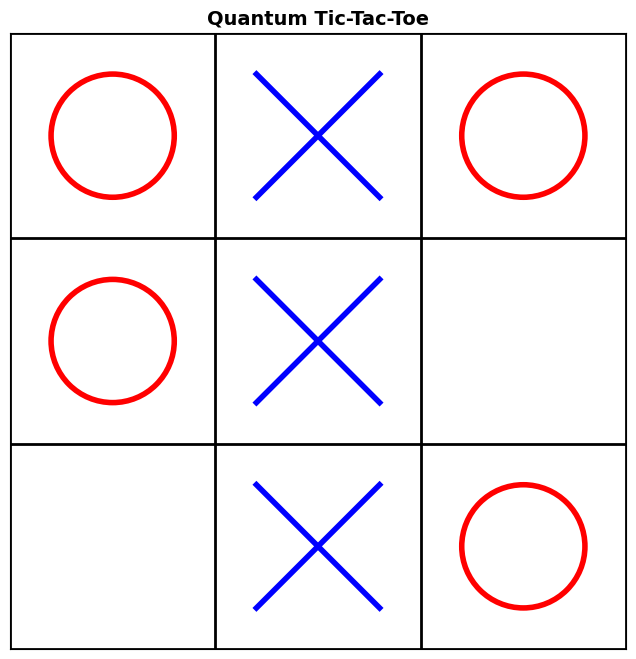


🎉 VOUS AVEZ GAGNÉ !


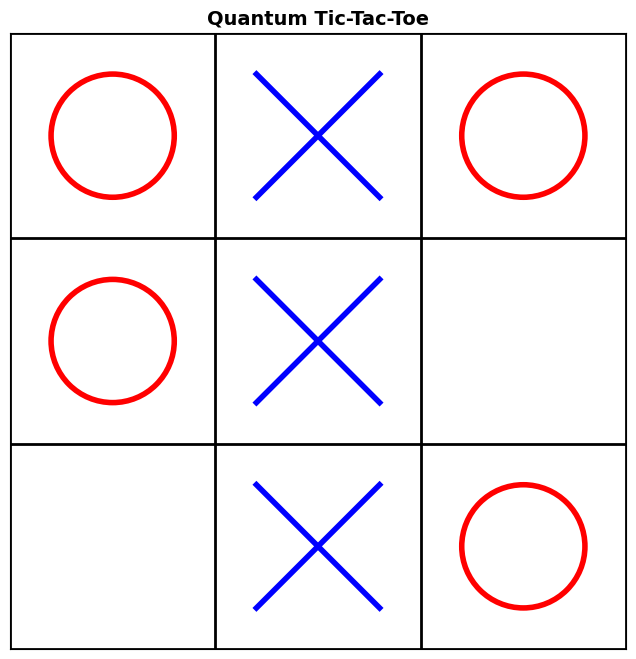

In [58]:
theta = train_ai(n_games=2)
save(theta)

# Cell 5 : PLAY
theta = load()
play_complete_game(theta)

# 9 Qubit Version

In this 9 qubit version we will try to use Grover's algorithm for the AI, the principle: Grover's algorithm searches among all possible cell pairs for those that lead to the most advantageous positions.
An oracle marks the "good" moves, and Grover amplification increases their probability of being measured.
Complexity: O(√N) instead of O(N) for a classical search.

We must now convert coordinates (row, column) into qubit indices, so we will map linearly onto 9 qubits.

References:
- Goff, A. (2006). "Quantum tic-tac-toe: A teaching tool for
   superposition, entanglement, and collapse"
   American Journal of Physics, 74(11), 962-973
- Grover, L. K. (1996). "A fast quantum mechanical algorithm for
    database search". Proceedings of the 28th ACM STOC, pp. 212-219

In [81]:
def cell_to_qubit(i, j):
    return i * N + j

In [83]:
def qubit_to_cell(q):
    return (q // N, q % N)

We will therefore initialize our new quantum game with a global 9-qubit circuit

In [86]:
def init_quantum_9q():
    board = [[0 for _ in range(N)] for _ in range(N)]
    marks_q = []
    global_circuit = QuantumCircuit(9, 9)
    return board, marks_q, global_circuit

Places a quantum mark in superposition on two cells of the global circuit.

Applies the Bell state (H → CNOT → X) directly on the qubits of the global circuit, creating (|10⟩ + |01⟩)/√2 between the two cells.
If a qubit already participates in another superposition, the gates compose, creating multi-partite entanglement (cycles).
Difference with the 2-qubit version: modifies the global circuit instead of creating a separate circuit.

In [89]:
def play_quantum_move_9q(board, marks_q, global_circuit, player, cell1, cell2):
    number = len(marks_q) + 1
    q1 = cell_to_qubit(*cell1)
    q2 = cell_to_qubit(*cell2)
    global_circuit.h(q1)
    global_circuit.cx(q1, q2)
    global_circuit.x(q2)

    marks_q.append((player, cell1, cell2, number))
    return board, marks_q

Rebuilds the global circuit after a partial measurement (cycle).

Difference from the old version: also reapplies the superpositions of unmeasured marks (previously, they were silently lost).

1. Encode classically occupied cells (X gate → |1⟩)
2. Reapply the Bell states of the remaining marks

In [92]:
def rebuild_circuit_9q(board, remaining_marks_q):
    global_circuit = QuantumCircuit(9, 9)

    for i in range(N):
        for j in range(N):
            if board[i][j] != 0:
                q = cell_to_qubit(i, j)
                global_circuit.x(q)

    for player, cell1, cell2, num in remaining_marks_q:
        q1 = cell_to_qubit(*cell1)
        q2 = cell_to_qubit(*cell2)
        global_circuit.h(q1)
        global_circuit.cx(q1, q2)
        global_circuit.x(q2)

    return global_circuit

### Quantum Measurement

In [95]:
def measure_cycle_9q(board, marks_q, global_circuit, cycle_marks_indices):
    occupied_cells = set()
    for i in range(N):
        for j in range(N):
            if board[i][j] != 0:
                occupied_cells.add((i, j))

    new_marks_q = []
    #print(f"\n  CYCLE MEASUREMENT ({len(cycle_marks_indices)} marks)")

    # Identify and measure the qubits in the cycle
    qubits_to_measure = set()
    for idx in cycle_marks_indices:
        player, cell1, cell2, num = marks_q[idx]
        qubits_to_measure.add(cell_to_qubit(*cell1))
        qubits_to_measure.add(cell_to_qubit(*cell2))

    qubits_to_measure = sorted(list(qubits_to_measure))

    for q in qubits_to_measure:
        global_circuit.measure(q, q)

    # Execute (1 shot = 1 quantum reality)
    simulator = AerSimulator()
    compiled = transpile(global_circuit, simulator)
    result = simulator.run(compiled, shots=1).result()
    counts = result.get_counts()
    bitstring = list(counts.keys())[0][::-1]

    print(f"  Measurement result : {bitstring}")

    # Resolve each mark in the cycle
    for idx in cycle_marks_indices:
        player, cell1, cell2, num = marks_q[idx]
        q1 = cell_to_qubit(*cell1)
        q2 = cell_to_qubit(*cell2)

        if bitstring[q1] == '1':
            preferred_cell, alt_cell = cell1, cell2
        else:
            preferred_cell, alt_cell = cell2, cell1

        if preferred_cell not in occupied_cells and board[preferred_cell[0]][preferred_cell[1]] == 0:
            final_cell = preferred_cell
        elif alt_cell not in occupied_cells and board[alt_cell[0]][alt_cell[1]] == 0:
            final_cell = alt_cell
        else:
            final_cell = None

        if final_cell:
            board[final_cell[0]][final_cell[1]] = player
            occupied_cells.add(final_cell)
            symbol = 'X' if player == 1 else 'O'
            print(f"    {symbol}{num} → {final_cell}")

    # Keep marks outside the cycle
    for idx, mark in enumerate(marks_q):
        if idx not in cycle_marks_indices:
            new_marks_q.append(mark)

    # Rebuild the circuit
    global_circuit = rebuild_circuit_9q(board, new_marks_q)

    return board, new_marks_q, global_circuit

Detects and resolves ALL entanglement cycles in a loop.
The old code only detected one cycle per turn. If two cycles form simultaneously,
the second remained unresolved until the next turn.
Replaces the single call to detect_cycle_entanglement + measure_cycle_9q in the game loop.

In [98]:
def resolve_all_cycles(board, marks_q, global_circuit):
    while True:
        cycle_detected, cycle_marks, cycle_cells = detect_cycle_entanglement(marks_q)
        if not cycle_detected:
            break
        print(f"\n  CYCLE DETECTED! Cells: {cycle_cells}")
        board, marks_q, global_circuit = measure_cycle_9q(
            board, marks_q, global_circuit, cycle_marks
        )
        #quantum_display(board, marks_q)

    return board, marks_q, global_circuit

Same principle as the 2-qubit version: Final measurement: collapses all remaining quantum marks.
Called at the end of the game when there are unmeasured marks remaining.
Same corrections as measure_cycle_9q (fallback + occupied cells).

In [101]:
def collapse_final_9q(board, marks_q, global_circuit):
    
    if not marks_q:
        return board, []

    print(f"\n  FINAL MEASUREMENT: {len(marks_q)} remaining marks")

    occupied_cells = set()
    for i in range(N):
        for j in range(N):
            if board[i][j] != 0:
                occupied_cells.add((i, j))

    qubits_to_measure = set()
    for player, cell1, cell2, num in marks_q:
        qubits_to_measure.add(cell_to_qubit(*cell1))
        qubits_to_measure.add(cell_to_qubit(*cell2))

    for q in sorted(qubits_to_measure):
        global_circuit.measure(q, q)

    simulator = AerSimulator()
    compiled = transpile(global_circuit, simulator)
    result = simulator.run(compiled, shots=1).result()
    counts = result.get_counts()
    bitstring = list(counts.keys())[0][::-1]

    for player, cell1, cell2, num in marks_q:
        q1 = cell_to_qubit(*cell1)
        q2 = cell_to_qubit(*cell2)

        if bitstring[q1] == '1':
            preferred_cell, alt_cell = cell1, cell2
        else:
            preferred_cell, alt_cell = cell2, cell1

        if preferred_cell not in occupied_cells and board[preferred_cell[0]][preferred_cell[1]] == 0:
            final_cell = preferred_cell
        elif alt_cell not in occupied_cells and board[alt_cell[0]][alt_cell[1]] == 0:
            final_cell = alt_cell
        else:
            final_cell = None

        if final_cell:
            board[final_cell[0]][final_cell[1]] = player
            occupied_cells.add(final_cell)
            symbol = 'X' if player == 1 else 'O'
            print(f"    {symbol}{num} → {final_cell}")

    return board, []

# 4. QUANTUM AI — GROVER'S ALGORITHM

Completely replaces the old AI (ai_circuit, evaluate_pair, choose_ai_move, train_ai). No more training needed.
Grover's algorithm (1996) searches among K cell pairs for those leading to the best positions, in O(√K).

Process:
1. Evaluate each pair with the heuristic
2. Mark the good pairs (top 25%) via a quantum oracle
3. Amplify their probability with Grover's diffuser
4. Measure → obtain a good pair with high probability

## Pair evaluation by grover: Evaluates a quantum move for the AI.

A quantum move collapses 50/50 on cell1 or cell2, so we evaluate both scenarios and take the average:

score = 0.5 × h(board + mark on cell1) + 0.5 × h(board + mark on cell2)
AI plays O (-1), it seeks the most negative score.

### cell_alignments — Which alignments does a cell cover?
To evaluate a quantum move, we want to know if the two chosen cells threaten different directions. This function returns the set of alignments that a cell belongs to: its row, its column, and possibly one or two diagonals.
For example cell (0,0) belongs to row_0, col_0 and main_diag (main diagonal, because i == j). Cell (1,1) in the center belongs to everything: row_1, col_1, main_diag and anti_diag — that's why the center is so strategically powerful.
Then in evaluate_pair_grover, we compare the alignments of the two cells. If cell1 covers {row_0, col_0, main_diag} and cell2 covers {row_2, col_2, anti_diag}, the union makes 6 distinct alignments and the intersection is empty — the pair threatens in 6 directions simultaneously. Maximum bonus. Conversely, if the two cells are on the same row and same diagonal, the intersection is large — it's redundant, penalty.

In [106]:
def cell_alignments(i, j):
    aligns = set()
    aligns.add(f"row_{i}")
    aligns.add(f"col_{j}")
    if i == j:
        aligns.add("main_diag")
    if i + j == N - 1:
        aligns.add("anti_diag")
    return aligns

###  Formulating the choice of cells as a quantum optimization problem
QAOA needs a QUBO (Quadratic Unconstrained Binary Optimization) problem as input. This function translates the board state into two sets of coefficients: h_i (individual value of each cell) and J_ij (synergy between cell pairs).
The h_i measure the importance of a single cell. The center is worth 3 (it touches 4 alignments), corners are worth 2 (3 alignments), edges are worth 1 (2 alignments). Then for each open alignment (row, column or diagonal without opponent mark), we add +1. A cell that participates in many free alignments is more valuable.
The J_ij measure how complementary two cells are. We calculate the difference between the number of distinct alignments covered (union) and the redundant alignments (intersection). The more the cells cover different directions, the stronger the synergy. Additionally, if the two cells are in the same free alignment (without opponent mark), it's a direct threat: we add +3 because placing marks on these two cells brings us closer to victory.
The result (cells, h, J) will then be encoded in the QAOA circuit: the h_i become individual RZ rotations, the J_ij become RZZ gates between qubit pairs. QAOA then optimizes the combination of cells that maximizes the total score C(x) = Σ h_i·x_i + Σ J_ij·x_i·x_j.

In [109]:
def build_board_qubo(board):
    cells = []
    for i in range(N):
        for j in range(N):
            if board[i][j] == 0:
                cells.append((i, j))

    n = len(cells)

    all_lines = []
    for i in range(N):
        all_lines.append([(i, j) for j in range(N)])
    for j in range(N):
        all_lines.append([(i, j) for i in range(N)])
    all_lines.append([(i, i) for i in range(N)])
    all_lines.append([(i, N - 1 - i) for i in range(N)])

    h = {}
    for idx, (ci, cj) in enumerate(cells):
        val = 0
        if (ci, cj) == (1, 1):
            val += 3
        elif (ci, cj) in [(0, 0), (0, 2), (2, 0), (2, 2)]:
            val += 2
        else:
            val += 1

        for line in all_lines:
            if (ci, cj) in line:
                opponent_present = any(
                    board[li][lj] != 0 and board[li][lj] == 1
                    for li, lj in line
                )
                if not opponent_present:
                    val += 1
        h[idx] = val

    J = {}
    for i in range(n):
        for j in range(i + 1, n):
            synergy = 0
            a_i = cell_alignments(*cells[i])
            a_j = cell_alignments(*cells[j])
            synergy += len(a_i | a_j) - len(a_i & a_j)

            for line in all_lines:
                if cells[i] in line and cells[j] in line:
                    opponent = any(
                        board[li][lj] == 1 for li, lj in line
                    )
                    if not opponent:
                        synergy += 3

            J[(i, j)] = synergy

    return cells, h, J

### Execute QAOA to score cells
This function is the heart of QAOA. It takes the board, builds the QUBO problem, then uses a quantum circuit to find which cells are strategically most important.
Limited to 7 qubits. If there are more than 7 available cells (beginning of game), we keep only the 7 with the best h_i. This is a compromise: beyond 7 qubits the simulator slows down too much for interactive play.
The QAOA circuit. For each layer (p_layers): first the cost layer that encodes the problem — RZ(γ·h_i) rotations on each qubit for individual values, then CNOT+RZ+CNOT blocks for J_ij synergies (this is the standard implementation of an RZZ gate). Then the mixer layer with RX(β) rotations on all qubits, which allows exploration of the solution space. The γ and β parameters control the balance between exploitation (cost) and exploration (mixing).
Classical optimization. The objective function executes the circuit 200 times, calculates the average score C(x) over all measured bitstrings, and returns the negative (because COBYLA minimizes, but we want to maximize C). COBYLA adjusts γ and β in 30 iterations to find the parameters that produce the best solutions.
Final scoring. Once the optimal parameters are found, we execute the circuit 500 times. For each cell, we count in what fraction of the 500 measurements its qubit was '1'. The more often a cell appears as '1', the more QAOA considers it part of the good solutions. This score (between 0 and 1) is then injected as the 4th criterion in evaluate_pair_grover.

In [112]:
def evaluate_cells_qaoa(board, p_layers=1):
    cells, h, J = build_board_qubo(board)
    n = len(cells)

    if n < 2:
        return {c: 0 for c in cells}

    # Limit to 7 qubits to keep simulation fast
    if n > 7:
        top_indices = sorted(h.keys(), key=lambda k: h[k], reverse=True)[:7]
        cells = [cells[i] for i in top_indices]
        old_h = h
        h = {new_i: old_h[old_i] for new_i, old_i in enumerate(top_indices)}
        J_new = {}
        for new_i, old_i in enumerate(top_indices):
            for new_j, old_j in enumerate(top_indices):
                if new_i < new_j and (old_i, old_j) in J:
                    J_new[(new_i, new_j)] = J[(old_i, old_j)]
        J = J_new
        n = len(cells)

    def qaoa_circuit(gamma, beta):
        qc = QuantumCircuit(n, n)
        qc.h(range(n))

        for layer in range(p_layers):
            for i in range(n):
                if i in h:
                    qc.rz(gamma[layer] * h[i], i)

            for (i, j), val in J.items():
                if i < n and j < n:
                    qc.cx(i, j)
                    qc.rz(gamma[layer] * val, j)
                    qc.cx(i, j)

            for i in range(n):
                qc.rx(beta[layer], i)

        qc.measure(range(n), range(n))
        return qc
    simulator = AerSimulator()
    def objective(params):
        gamma = params[:p_layers]
        beta = params[p_layers:]

        qc = qaoa_circuit(gamma, beta)
        compiled = transpile(qc, simulator)
        result = simulator.run(compiled, shots=200).result()
        counts = result.get_counts()

        total = 0
        for bitstring, count in counts.items():
            bits = bitstring[::-1]
            cost = 0
            for i in range(n):
                if bits[i] == '1' and i in h:
                    cost += h[i]
            for (i, j), val in J.items():
                if i < len(bits) and j < len(bits):
                    if bits[i] == '1' and bits[j] == '1':
                        cost += val
            total += cost * count

        return -total / sum(counts.values())

    from scipy.optimize import minimize
    params_init = np.random.uniform(0, np.pi, 2 * p_layers)
    result = minimize(objective, params_init, method='COBYLA',
                      options={'maxiter': 30})

    gamma_opt = result.x[:p_layers]
    beta_opt = result.x[p_layers:]
    qc = qaoa_circuit(gamma_opt, beta_opt)
    compiled = transpile(qc, simulator)
    counts = simulator.run(compiled, shots=500).result().get_counts()

    scores = {c: 0.0 for c in cells}
    total_shots = sum(counts.values())

    for bitstring, count in counts.items():
        bits = bitstring[::-1]
        for i in range(min(n, len(bits))):
            if bits[i] == '1':
                scores[cells[i]] += count / total_shots

    return scores

###  Complete evaluation of a quantum move
This is the central function of the AI. It rates each cell pair on 4 combined criteria.
Criterion 1 — Positional score. We simulate the two collapse scenarios: "what if the mark falls on cell1?" and "what if it falls on cell2?". We evaluate each scenario with the heuristic and take the average. This makes sense: a quantum move has a 50% chance of landing on each cell.
Criterion 2 — Alignment diversity. We compare the alignments of the two cells. The larger the union (different directions covered), the higher the bonus. The larger the intersection (same directions), the stronger the penalty. The center and corners receive an additional bonus because they are strategically dominant positions. Everything is multiplied by ai_player (-1) so that bonuses are negative (the AI minimizes the score).
Criterion 3 — Cycle awareness. We simulate adding this mark and check if it creates a cycle. If so, we simulate both resolution directions ('10' and '01') and evaluate both resulting boards. The AI takes the worst case (max for O, because the most positive score is worst for it). This is minimax applied to the cycle: the AI assumes the collapse will disadvantage it. The final score is weighted 40% direct evaluation + 60% cycle, because the cycle forces immediate collapse so its impact is dominant.
Criterion 4 — QAOA score. If QAOA was executed this turn, we add the importance scores of both cells. A pair whose two cells have high QAOA scores (frequently selected by quantum optimization) receives an additional bonus. This is the link between QAOA (which evaluates cells individually) and Grover (which selects pairs).

In [115]:
def evaluate_pair_grover(board, cell1, cell2, marks_q, ai_player=-1, qaoa_scores=None):
    # --- 1. Positional score ---
    b1 = deepcopy(board)
    b1[cell1[0]][cell1[1]] = ai_player
    s1 = heuristic(b1)

    b2 = deepcopy(board)
    b2[cell2[0]][cell2[1]] = ai_player
    s2 = heuristic(b2)

    score = (s1 + s2) / 2.0

    # --- 2. Alignment diversity ---
    a1 = cell_alignments(*cell1)
    a2 = cell_alignments(*cell2)
    score += len(a1 | a2) * 15 * ai_player
    score -= len(a1 & a2) * 10 * ai_player

    for cell in [cell1, cell2]:
        if cell == (1, 1):
            score += 20 * ai_player
        elif cell in [(0, 0), (0, 2), (2, 0), (2, 2)]:
            score += 10 * ai_player

    # --- 3. Cycle awareness ---
    test_marks = marks_q + [(ai_player, cell1, cell2, len(marks_q) + 1)]
    cycle_detected, cycle_marks, _ = detect_cycle_entanglement(test_marks)

    if cycle_detected:
        resolution_scores = []
        for direction in ['10', '01']:
            sim_board = deepcopy(board)
            occupied = set()
            for i in range(N):
                for j in range(N):
                    if sim_board[i][j] != 0:
                        occupied.add((i, j))

            for idx in cycle_marks:
                player_sim, c1_sim, c2_sim, num_sim = test_marks[idx]
                if direction == '10':
                    pref, alt = c1_sim, c2_sim
                else:
                    pref, alt = c2_sim, c1_sim

                if pref not in occupied and sim_board[pref[0]][pref[1]] == 0:
                    final = pref
                elif alt not in occupied and sim_board[alt[0]][alt[1]] == 0:
                    final = alt
                else:
                    final = None

                if final:
                    sim_board[final[0]][final[1]] = player_sim
                    occupied.add(final)

            resolution_scores.append(heuristic(sim_board))

        if ai_player == -1:
            cycle_score = max(resolution_scores)
        else:
            cycle_score = min(resolution_scores)

        score = 0.4 * score + 0.6 * cycle_score

    # --- 4. QAOA score (NEW) ---
    if qaoa_scores:
        qaoa1 = qaoa_scores.get(cell1, 0)
        qaoa2 = qaoa_scores.get(cell2, 0)
        score += (qaoa1 + qaoa2) * 50 * ai_player

    return score

## Grover Oracle: flips the phase of states |i⟩ marked as "good moves".
Grover Oracle — How it works concretely
The oracle must flip the phase of a specific state. For example, to mark index 5 = 101 on 3 qubits, we want |101⟩ → −|101⟩ without affecting other states.
The problem is that the MCZ (multi-controlled Z) gate only flips the state |111⟩ (all qubits at 1). But our target is |101⟩, not |111⟩.
The trick: we put X gates on the qubits that should be 0 in our target. This temporarily transforms |101⟩ into |111⟩. We apply MCZ (implemented by H+MCX+H on the last qubit), which flips the phase of |111⟩. Then we put back the X gates to undo the transformation. In the end, only the state |101⟩ has had its phase flipped.
We repeat this operation for each "good move" index. At the oracle output, all good moves have a negative amplitude, others are unchanged.

In [118]:
def build_grover_oracle(qc, marked_indices, n_qubits):
    for idx in marked_indices:
        binary = format(idx, f'0{n_qubits}b')

        for bit_pos, bit in enumerate(binary):
            if bit == '0':
                qc.x(bit_pos)

        if n_qubits == 1:
            qc.z(0)
        else:
            qc.h(n_qubits - 1)
            qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
            qc.h(n_qubits - 1)

        for bit_pos, bit in enumerate(binary):
            if bit == '0':
                qc.x(bit_pos)

## Diffusion operator: D = 2|ψ⟩⟨ψ| - I
Grover Diffuser — Amplify the good moves
After the oracle, the good moves have negative amplitude and the bad ones positive amplitude. The diffuser reflects all amplitudes around their average, which makes the negative amplitudes "bounce" above the others.
Mathematically this is operator D = 2|ψ⟩⟨ψ| − I, where |ψ⟩ is the uniform superposition. In practice it's implemented in 5 steps:

H on all qubits: brings back to the computational basis
X on all qubits: transforms |000...0⟩ into |111...1⟩
H+MCX+H on the last qubit: flips the phase of |111...1⟩ only (this is MCZ, exactly like in the oracle)
X on all qubits: undoes the transformation
H on all qubits: returns to the superposition basis

The net result: amplitudes that were below average (the good moves, made negative by the oracle) end up above. With each oracle+diffuser iteration, the good moves gain probability and the bad ones lose it.

In [121]:
def build_grover_diffuser(qc, n_qubits):
    qc.h(range(n_qubits))
    qc.x(range(n_qubits))

    qc.h(n_qubits - 1)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)

    qc.x(range(n_qubits))
    qc.h(range(n_qubits))

### grover_search
This function assembles everything. It receives a list of scores (one per cell pair) and returns the index of the pair chosen by Grover.
- Step 1 — Adaptive threshold. We sort the scores and take the top 25% as "good moves". The AI plays O (it minimizes), so the lowest scores are the best. If all pairs are good or none are, we directly return the best classically — no need for Grover.
- Step 2 — Size the circuit. We have K pairs to encode on n = ⌈log₂(K)⌉ qubits. For example 36 pairs → 6 qubits (2⁶ = 64 states). States from 36 to 63 are "parasitic" that do not correspond to any pair.
- Step 3 — Number of iterations. The formula ⌊π/4 × √(K/M)⌋ gives the optimal number of oracle+diffuser iterations. With K=36 and M=9: ⌊π/4 × 2⌋ = 1 iteration.
- Step 4 — Build and execute. We put all qubits in superposition (H), then loop r times: oracle (marks the good ones) + diffuser (amplifies the good ones). We measure with a single shot.
- Step 5 — Read the result. The measured bitstring is converted to an integer (e.g., '000101' → 5). If the index is < K, it's a valid pair, we return it. If the index is ≥ K (parasitic state due to power of two padding), we return the best classical move as fallback. This guarantees that the AI always plays a valid move, even if Grover lands on a parasitic state.

In [124]:
def grover_search(pair_scores):
    
    K = len(pair_scores)
    if K == 0:
        return 0

    # Adaptive threshold: top 25%
    sorted_scores = sorted(pair_scores)
    threshold = sorted_scores[max(1, K // 4) - 1]

    good_indices = [i for i, s in enumerate(pair_scores) if s <= threshold]
    M = len(good_indices)

    if M == 0 or M == K:
        return pair_scores.index(min(pair_scores))

    # Grover circuit
    n_qubits = max(2, math.ceil(math.log2(K)))
    n_iterations = max(1, int(math.pi / 4 * math.sqrt(K / M)))

    qc = QuantumCircuit(n_qubits, n_qubits)
    qc.h(range(n_qubits))

    for _ in range(n_iterations):
        build_grover_oracle(qc, good_indices, n_qubits)
        build_grover_diffuser(qc, n_qubits)

    qc.measure(range(n_qubits), range(n_qubits))

    simulator = AerSimulator()
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=1).result()
    counts = result.get_counts()
    measurement = list(counts.keys())[0][::-1]
    measured_index = int(measurement, 2)

    if measured_index < K:
        return measured_index
    else:
        return pair_scores.index(min(pair_scores))

The AI chooses its move with Grover's algorithm.

1. Generate all available cell pairs
2. Evaluate each pair (average of the 2 collapse scenarios)
3. Grover selects a good pair

Replaces choose_ai_move + ai_circuit + train_ai.
No more training needed.

In [127]:
#mode='heuristic': classical evaluation (fast)
#mode='qaoa'        : QAOA evaluates cells, then Grover selects
#In both cases, Grover does the final selection.
def choose_ai_grover_move(board, marks_q, mode='heuristic'):
    cells = available_cells_quantum(board, marks_q)
    if len(cells) < 2:
        return None, None

    pairs = []
    for i in range(len(cells)):
        for j in range(i + 1, len(cells)):
            pairs.append((cells[i], cells[j]))

    if not pairs:
        return None, None

    if mode == 'qaoa':
        qaoa_scores = evaluate_cells_qaoa(board, p_layers=1)
        scores = [evaluate_pair_grover(board, c1, c2, marks_q,
                                        qaoa_scores=qaoa_scores)
                  for c1, c2 in pairs]
    else:
        scores = [evaluate_pair_grover(board, c1, c2, marks_q)
                  for c1, c2 in pairs]

    chosen_index = grover_search(scores)
    return pairs[chosen_index]

# 5. GAME LOOP (MODIFIED for Grover)

Complete game Human (X) vs Grover AI (O).
Uses the functions from the 2-qubit version for: quantum_display, detect_cycle_entanglement, check_victory

In [131]:
def play_complete_game_9q(display_circuit=True):
    print("  QUANTUM TIC-TAC-TOE  —  Grover AI (9 qubits)")
    board, marks_q, global_circuit = init_quantum_9q()
    turn = 0

    choice = input("\nWho starts? (1=You, 2=AI) : ")
    human_starts = (choice == '1')
    print("\n  You play X, AI plays O\n")

    while turn < 10:
        print(f"  TURN {turn + 1}")
        if (human_starts and turn % 2 == 0) or (not human_starts and turn % 2 == 1):
            print("\n  YOUR TURN")
            cells = available_cells_quantum(board, marks_q)
            if len(cells) < 2:
                break

            quantum_display(board, marks_q)
            print(f"\n  Available cells: {cells}")

            while True:
                try:
                    i1 = int(input("  Cell 1 - row (0-2) : "))
                    j1 = int(input("  Cell 1 - column (0-2) : "))
                    i2 = int(input("  Cell 2 - row (0-2) : "))
                    j2 = int(input("  Cell 2 - column (0-2) : "))
                    if (i1, j1) in cells and (i2, j2) in cells and (i1, j1) != (i2, j2):
                        break
                    print("  Invalid choice.")
                except ValueError:
                    print("  Invalid input.")

            board, marks_q = play_quantum_move_9q(
                board, marks_q, global_circuit, 1, (i1, j1), (i2, j2)
            )
            
            print(f"  You play: ({i1},{j1}) and ({i2},{j2})")
            ##print(global_circuit.draw(output='text', fold=80))

        else:
            print("\n  AI TURN (Grover algorithm)")
            c1, c2 = choose_ai_grover_move(board, marks_q)
            if c1 is None:
                break

            board, marks_q = play_quantum_move_9q(
                board, marks_q, global_circuit, -1, c1, c2
            )
            
            print(f"  AI plays: {c1} and {c2}")
            ##print(global_circuit.draw(output='text', fold=80))

        if display_circuit:
            print(f"\n  Circuit ({global_circuit.num_qubits}q, {global_circuit.size()} gates) :")
            print(global_circuit.draw(output='text', fold=80))

        quantum_display(board, marks_q)

        board, marks_q, global_circuit = resolve_all_cycles(board, marks_q, global_circuit)

        if check_victory(board, 1):
            print("\n  YOU WON !")
            return board, marks_q, global_circuit
        if check_victory(board, -1):
            print("\n  AI WON !")
            return board, marks_q, global_circuit

        turn += 1

    if marks_q:
        print("\n  Final collapse")
        board, marks_q = collapse_final_9q(board, marks_q, global_circuit)
        quantum_display(board, marks_q)

    if check_victory(board, 1):
        print("  YOU WON !")
    elif check_victory(board, -1):
        print("  AI WON !")
    else:
        print("  DRAW !")

    return board, marks_q, global_circuit

Evaluates Grover AI against a random player over n games.

In [134]:
def play_ai_vs_random(n_games, mode='heuristic'):
    ai_wins, random_wins, draws = 0, 0, 0

    for game in range(n_games):
        board, marks_q, global_circuit = init_quantum_9q()

        game_finished = False
        for turn in range(10):
            c1, c2 = choose_ai_grover_move(board, marks_q, mode=mode)
            if c1 is None:
                break
            board, marks_q = play_quantum_move_9q(
                board, marks_q, global_circuit, -1, c1, c2
            )
            #print(global_circuit.draw(output='text', fold=80))
            board, marks_q, global_circuit = resolve_all_cycles(board, marks_q, global_circuit)
            if check_victory(board, -1):
                ai_wins += 1
                game_finished = True
                break

            cells = available_cells_quantum(board, marks_q)
            if len(cells) < 2:
                break
            c1, c2 = random.sample(cells, 2)
            board, marks_q = play_quantum_move_9q(
                board, marks_q, global_circuit, 1, c1, c2
            )
            ##print(global_circuit.draw(output='text', fold=80))
            board, marks_q, global_circuit = resolve_all_cycles(board, marks_q, global_circuit)
            if check_victory(board, 1):
                random_wins += 1
                game_finished = True
                break

        if not game_finished:
            if marks_q:
                board, marks_q = collapse_final_9q(board, marks_q, global_circuit)
            if check_victory(board, -1):
                ai_wins += 1
            elif check_victory(board, 1):
                random_wins += 1
            else:
                draws += 1

    print(f"  RESULTS over {n_games} games ({mode})")
    print(f"  Grover AI (O)  : {ai_wins:3d} ({100*ai_wins/n_games:.1f}%)")
    print(f"  Random (X)     : {random_wins:3d} ({100*random_wins/n_games:.1f}%)")
    print(f"  Draw           : {draws:3d} ({100*draws/n_games:.1f}%)")
    return ai_wins, random_wins, draws

  QUANTUM TIC-TAC-TOE  —  IA Grover (9 qubits)



Qui commence ? (1=Vous, 2=IA) :  1



  Vous jouez X, l'IA joue O


  TOUR 1

  VOTRE TOUR


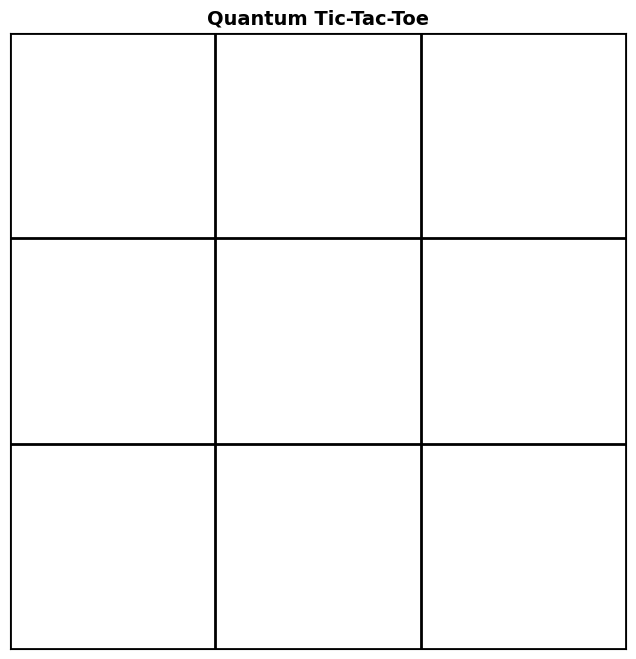


  Cases disponibles : [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


  Case 1 - ligne (0-2) :  0
  Case 1 - colonne (0-2) :  0
  Case 2 - ligne (0-2) :  0
  Case 2 - colonne (0-2) :  1


  Vous jouez : (0,0) et (0,1)

  Circuit (9q, 3 portes) :
     ┌───┐          
q_0: ┤ H ├──■───────
     └───┘┌─┴─┐┌───┐
q_1: ─────┤ X ├┤ X ├
          └───┘└───┘
q_2: ───────────────
                    
q_3: ───────────────
                    
q_4: ───────────────
                    
q_5: ───────────────
                    
q_6: ───────────────
                    
q_7: ───────────────
                    
q_8: ───────────────
                    
c: 9/═══════════════
                    


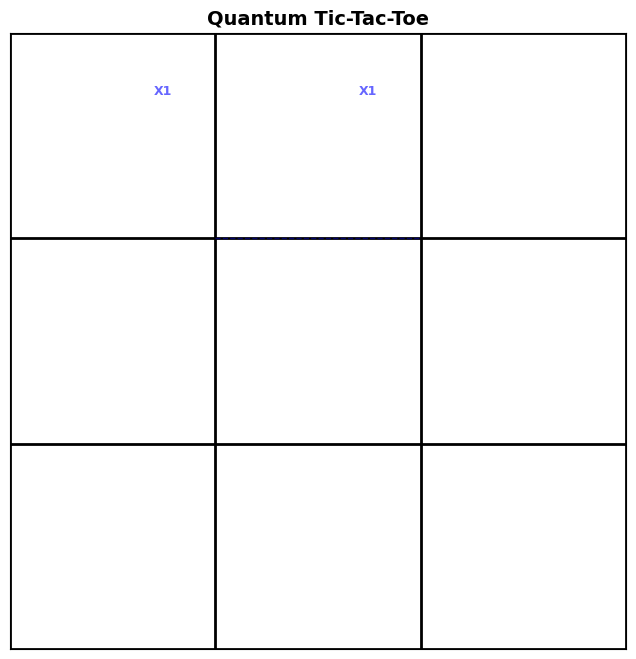


  TOUR 2

  TOUR IA (algorithme de Grover)
  L'IA joue : (0, 0) et (2, 0)

  Circuit (9q, 6 portes) :
     ┌───┐     ┌───┐          
q_0: ┤ H ├──■──┤ H ├──■───────
     └───┘┌─┴─┐├───┤  │       
q_1: ─────┤ X ├┤ X ├──┼───────
          └───┘└───┘  │       
q_2: ─────────────────┼───────
                      │       
q_3: ─────────────────┼───────
                      │       
q_4: ─────────────────┼───────
                      │       
q_5: ─────────────────┼───────
                    ┌─┴─┐┌───┐
q_6: ───────────────┤ X ├┤ X ├
                    └───┘└───┘
q_7: ─────────────────────────
                              
q_8: ─────────────────────────
                              
c: 9/═════════════════════════
                              


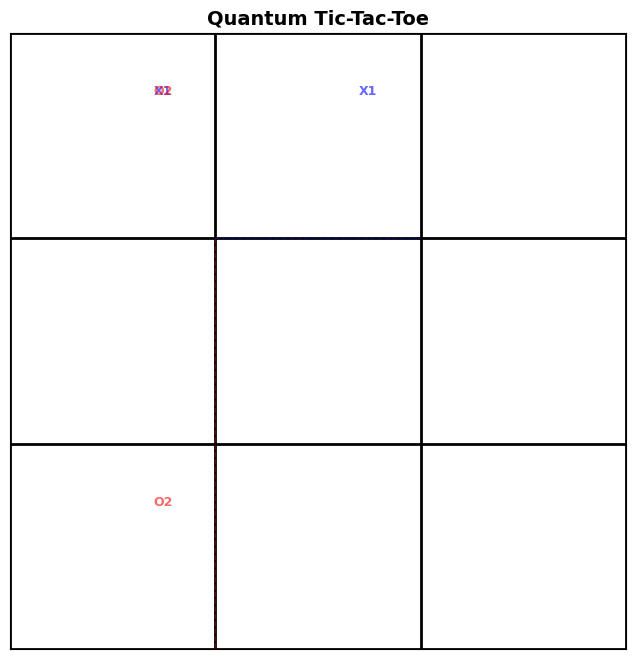


  TOUR 3

  VOTRE TOUR


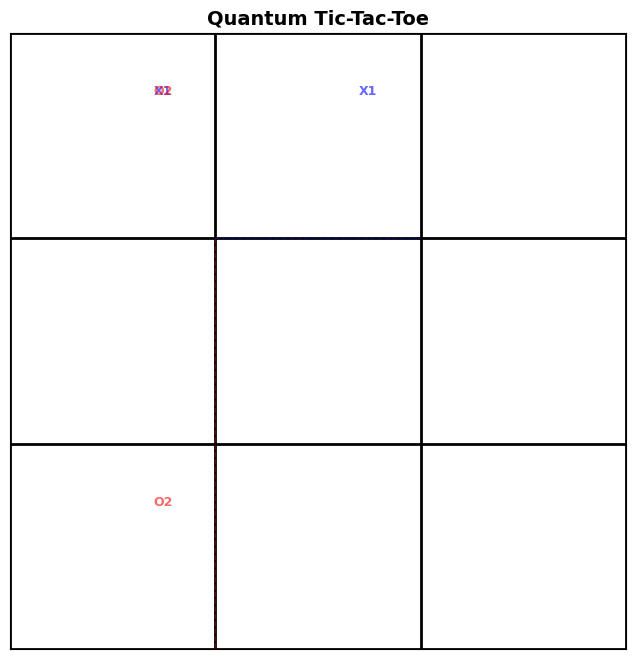


  Cases disponibles : [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


  Case 1 - ligne (0-2) :  9
  Case 1 - colonne (0-2) :  1
  Case 2 - ligne (0-2) :  0
  Case 2 - colonne (0-2) :  1


  Choix invalide.


  Case 1 - ligne (0-2) :  0
  Case 1 - colonne (0-2) :  0
  Case 2 - ligne (0-2) :  0
  Case 2 - colonne (0-2) :  1


  Vous jouez : (0,0) et (0,1)

  Circuit (9q, 9 portes) :
     ┌───┐     ┌───┐     ┌───┐          
q_0: ┤ H ├──■──┤ H ├──■──┤ H ├──■───────
     └───┘┌─┴─┐├───┤  │  └───┘┌─┴─┐┌───┐
q_1: ─────┤ X ├┤ X ├──┼───────┤ X ├┤ X ├
          └───┘└───┘  │       └───┘└───┘
q_2: ─────────────────┼─────────────────
                      │                 
q_3: ─────────────────┼─────────────────
                      │                 
q_4: ─────────────────┼─────────────────
                      │                 
q_5: ─────────────────┼─────────────────
                    ┌─┴─┐┌───┐          
q_6: ───────────────┤ X ├┤ X ├──────────
                    └───┘└───┘          
q_7: ───────────────────────────────────
                                        
q_8: ───────────────────────────────────
                                        
c: 9/═══════════════════════════════════
                                        


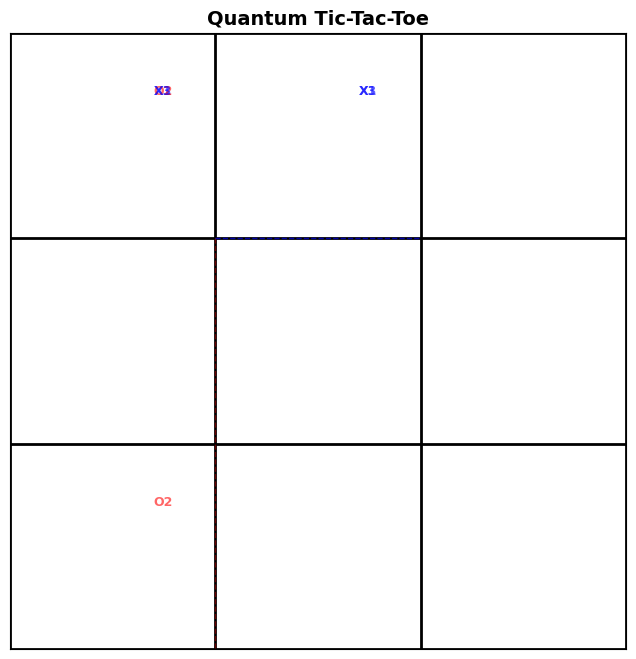


  CYCLE DÉTECTÉ ! Cases : [(0, 1), (2, 0), (0, 0)]
  Résultat mesure : 000000000
    X1 → (0, 1)
    O2 → (2, 0)
    X3 → (0, 0)

  TOUR 4

  TOUR IA (algorithme de Grover)
  L'IA joue : (1, 1) et (2, 2)

  Circuit (9q, 6 portes) :
     ┌───┐          
q_0: ┤ X ├──────────
     ├───┤          
q_1: ┤ X ├──────────
     └───┘          
q_2: ───────────────
                    
q_3: ───────────────
     ┌───┐          
q_4: ┤ H ├──■───────
     └───┘  │       
q_5: ───────┼───────
     ┌───┐  │       
q_6: ┤ X ├──┼───────
     └───┘  │       
q_7: ───────┼───────
          ┌─┴─┐┌───┐
q_8: ─────┤ X ├┤ X ├
          └───┘└───┘
c: 9/═══════════════
                    


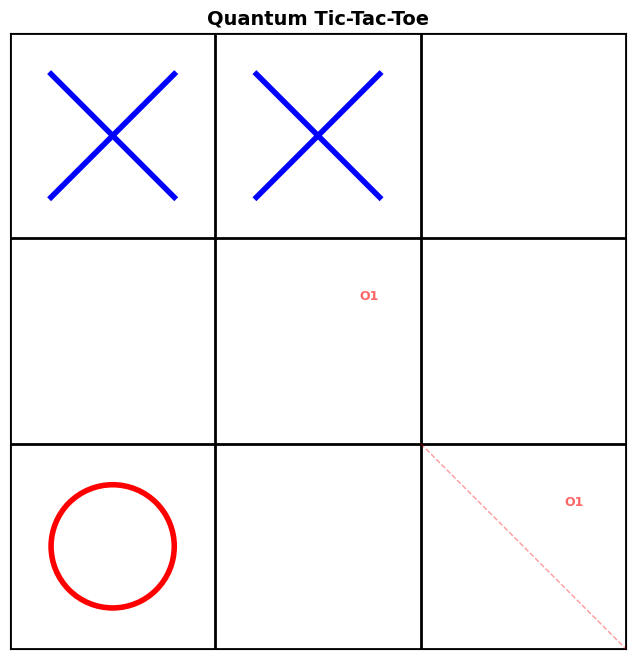


  TOUR 5

  VOTRE TOUR


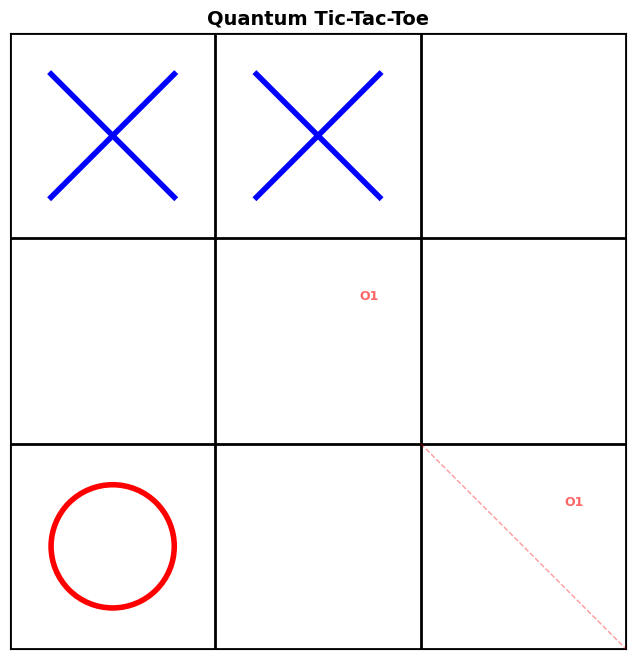


  Cases disponibles : [(0, 2), (1, 0), (1, 1), (1, 2), (2, 1), (2, 2)]


  Case 1 - ligne (0-2) :  0
  Case 1 - colonne (0-2) :  2
  Case 2 - ligne (0-2) :  1
  Case 2 - colonne (0-2) :  0


  Vous jouez : (0,2) et (1,0)

  Circuit (9q, 9 portes) :
     ┌───┐          
q_0: ┤ X ├──────────
     ├───┤          
q_1: ┤ X ├──────────
     ├───┤          
q_2: ┤ H ├──■───────
     └───┘┌─┴─┐┌───┐
q_3: ─────┤ X ├┤ X ├
     ┌───┐└───┘└───┘
q_4: ┤ H ├──■───────
     └───┘  │       
q_5: ───────┼───────
     ┌───┐  │       
q_6: ┤ X ├──┼───────
     └───┘  │       
q_7: ───────┼───────
          ┌─┴─┐┌───┐
q_8: ─────┤ X ├┤ X ├
          └───┘└───┘
c: 9/═══════════════
                    


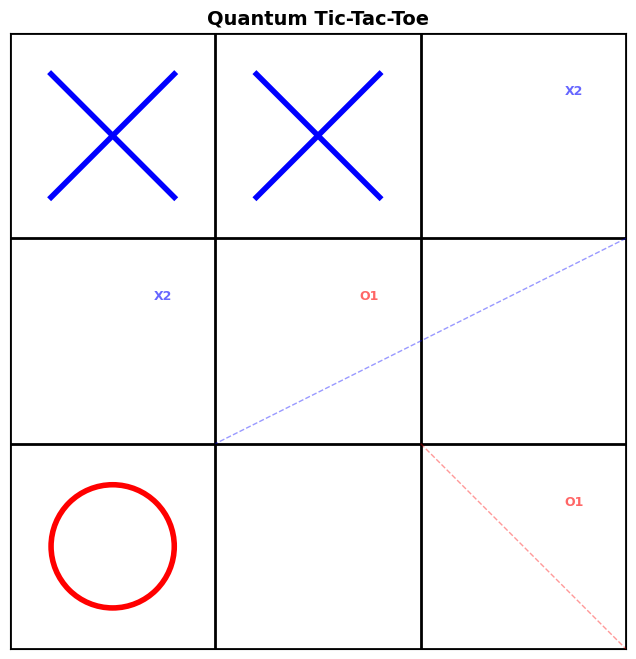


  TOUR 6

  TOUR IA (algorithme de Grover)
  L'IA joue : (0, 2) et (1, 1)

  Circuit (9q, 12 portes) :
     ┌───┐                    
q_0: ┤ X ├────────────────────
     ├───┤                    
q_1: ┤ X ├────────────────────
     ├───┤     ┌───┐          
q_2: ┤ H ├──■──┤ H ├──■───────
     └───┘┌─┴─┐├───┤  │       
q_3: ─────┤ X ├┤ X ├──┼───────
     ┌───┐└───┘└───┘┌─┴─┐┌───┐
q_4: ┤ H ├──■───────┤ X ├┤ X ├
     └───┘  │       └───┘└───┘
q_5: ───────┼─────────────────
     ┌───┐  │                 
q_6: ┤ X ├──┼─────────────────
     └───┘  │                 
q_7: ───────┼─────────────────
          ┌─┴─┐┌───┐          
q_8: ─────┤ X ├┤ X ├──────────
          └───┘└───┘          
c: 9/═════════════════════════
                              


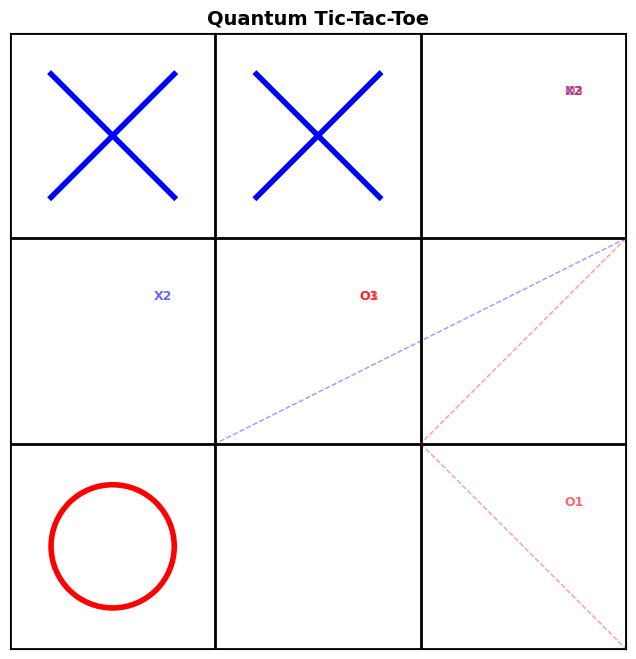


  TOUR 7

  VOTRE TOUR


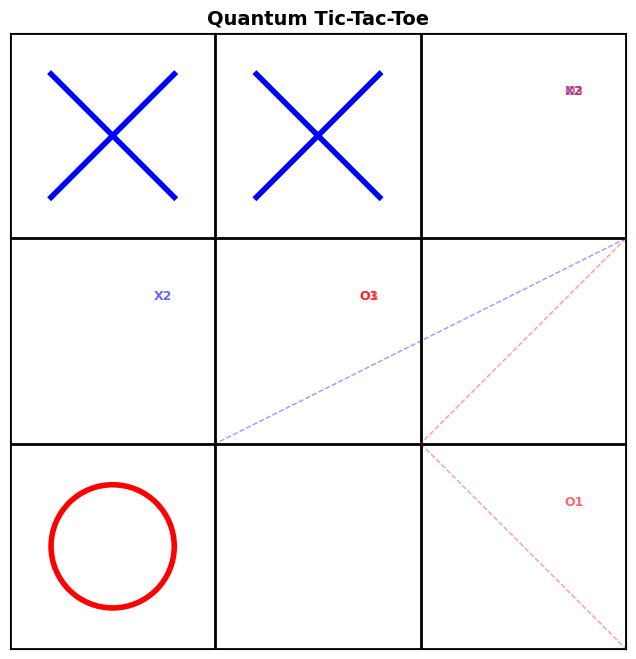


  Cases disponibles : [(0, 2), (1, 0), (1, 1), (1, 2), (2, 1), (2, 2)]


  Case 1 - ligne (0-2) :  0
  Case 1 - colonne (0-2) :  2
  Case 2 - ligne (0-2) :  1
  Case 2 - colonne (0-2) :  0


  Vous jouez : (0,2) et (1,0)

  Circuit (9q, 15 portes) :
     ┌───┐                              
q_0: ┤ X ├──────────────────────────────
     ├───┤                              
q_1: ┤ X ├──────────────────────────────
     ├───┤     ┌───┐     ┌───┐          
q_2: ┤ H ├──■──┤ H ├──■──┤ H ├──■───────
     └───┘┌─┴─┐├───┤  │  └───┘┌─┴─┐┌───┐
q_3: ─────┤ X ├┤ X ├──┼───────┤ X ├┤ X ├
     ┌───┐└───┘└───┘┌─┴─┐┌───┐└───┘└───┘
q_4: ┤ H ├──■───────┤ X ├┤ X ├──────────
     └───┘  │       └───┘└───┘          
q_5: ───────┼───────────────────────────
     ┌───┐  │                           
q_6: ┤ X ├──┼───────────────────────────
     └───┘  │                           
q_7: ───────┼───────────────────────────
          ┌─┴─┐┌───┐                    
q_8: ─────┤ X ├┤ X ├────────────────────
          └───┘└───┘                    
c: 9/═══════════════════════════════════
                                        


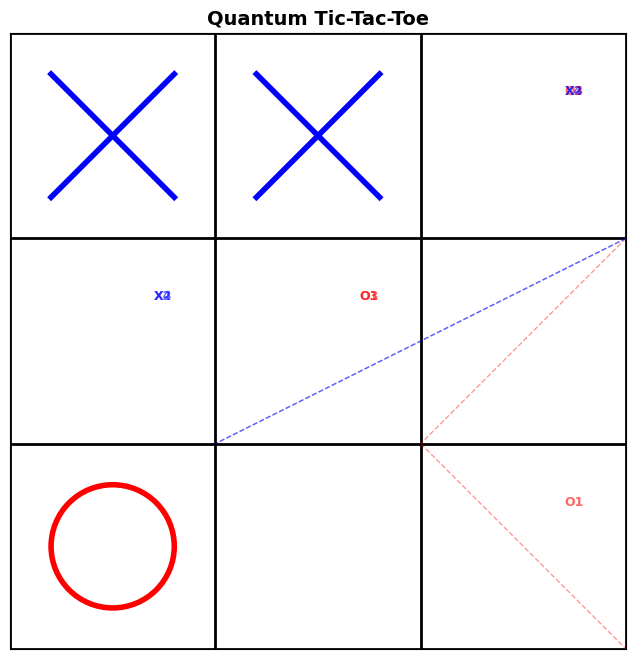


  CYCLE DÉTECTÉ ! Cases : [(1, 1), (1, 0), (0, 2)]
  Résultat mesure : 000000000
    O3 → (1, 1)
    X2 → (1, 0)
    X4 → (0, 2)

  VOUS AVEZ GAGNÉ !


In [136]:
# #Play against AI:
board, marks, circuit = play_complete_game_9q()

#Evaluate AI:
#print("heuristic mode")
#play_ai_vs_random(1000, mode='optimal_heuristic')
#print("\n qaoa mode")
#play_ai_vs_random(100, mode='qaoa')

# ELO TOURNAMENT — QUANTUM TIC-TAC-TOE

### QUANTUM MINIMAX ALPHA-BETA AI

- Minimax alpha-beta adapted to Quantum Tic-Tac-Toe.
- Heuristic: evaluate_pair_grover (aware of cycles,
- alignments and superposition) — your best heuristic.
- player  1 → maximizes
- player -1 → minimizes

In [ ]:
def quantum_minimax(board, marks_q, max_depth, player):
    def leaf_score(board, marks_q_sim, current_player):
        winner = determine_winner(board)
        if winner == "Player 1 has won": return  10000
        if winner == "Player 2 has won": return -10000
        if winner == "Draw":           return  0

        cells = available_cells_quantum(board, marks_q_sim)
        if len(cells) < 2:
            return optimal_heuristic(board)

        scores = [
            evaluate_pair_grover(
                board, cells[i], cells[j],
                marks_q_sim, ai_player=current_player
            )
            for i in range(len(cells))
            for j in range(i + 1, len(cells))
        ]
        return max(scores) if current_player == 1 else min(scores)

    def score(board, marks_q_sim, depth, current_player, alpha, beta):
        opponent = -current_player

        winner = determine_winner(board)
        if depth == max_depth or winner is not None:
            return leaf_score(board, marks_q_sim, current_player)

        cells = available_cells_quantum(board, marks_q_sim)
        if len(cells) < 2:
            return leaf_score(board, marks_q_sim, current_player)

        pairs = [
            (cells[i], cells[j])
            for i in range(len(cells))
            for j in range(i + 1, len(cells))
        ]

        if current_player == 1:
            max_score = float('-inf')
            best_pair = None

            for c1, c2 in pairs:
                s_direct = evaluate_pair_grover(
                    board, c1, c2, marks_q_sim, ai_player=current_player
                )

                b1 = deepcopy(board)
                b1[c1[0]][c1[1]] = current_player
                b2 = deepcopy(board)
                b2[c2[0]][c2[1]] = current_player

                s1 = score(b1, marks_q_sim, depth + 1, opponent, alpha, beta)
                s2 = score(b2, marks_q_sim, depth + 1, opponent, alpha, beta)

                s = 0.5 * s_direct + 0.5 * (s1 + s2) / 2.0

                if s > max_score:
                    max_score = s
                    best_pair = (c1, c2)

                alpha = max(alpha, max_score)
                if beta <= alpha:
                    break

            if depth == 0:
                return max_score, best_pair
            return max_score

        else:
            min_score = float('inf')
            best_pair = None

            for c1, c2 in pairs:
                s_direct = evaluate_pair_grover(
                    board, c1, c2, marks_q_sim, ai_player=current_player
                )

                b1 = deepcopy(board)
                b1[c1[0]][c1[1]] = current_player
                b2 = deepcopy(board)
                b2[c2[0]][c2[1]] = current_player

                s1 = score(b1, marks_q_sim, depth + 1, opponent, alpha, beta)
                s2 = score(b2, marks_q_sim, depth + 1, opponent, alpha, beta)

                s = 0.5 * s_direct + 0.5 * (s1 + s2) / 2.0

                if s < min_score:
                    min_score = s
                    best_pair = (c1, c2)

                beta = min(beta, min_score)
                if beta <= alpha:
                    break

            if depth == 0:
                return min_score, best_pair
            return min_score

    result = score(
        board, marks_q, 0, player,
        float('-inf'), float('inf')
    )
    _, pair = result
    if pair is None:
        return None, None
    return pair[0], pair[1]

In [ ]:
def choose_quantum_minimax_move(board, marks_q, player=-1, depth=3):
    cells = available_cells_quantum(board, marks_q)
    if len(cells) < 2:
        return None, None
    return quantum_minimax(board, marks_q, depth, player)

### Scoring ELO et tournoi entre les IA

In [ ]:
def calculate_elo(ratings, ai1, ai2, result, k=64):
    r1, r2 = ratings[ai1], ratings[ai2]
    E1 = 1 / (1 + 10 ** ((r2 - r1) / 400))
    E2 = 1 - E1
    S1 = 1.0 if result == 1 else (0.5 if result == 0 else 0.0)
    S2 = 1.0 - S1
    ratings[ai1] += k * (S1 - E1)
    ratings[ai2] += k * (S2 - E2)
    return ratings

In [ ]:
def play_ai_vs_ai(ai1_name, ai2_name):
    board, marks_q, global_circuit = init_quantum_9q()
    player = 1
    config = {1: ai1_name, -1: ai2_name}

    for _ in range(10):
        ai_name = config[player]
        cells = available_cells_quantum(board, marks_q)
        if len(cells) < 2:
            break

        if ai_name == 'random':
            c1, c2 = random.sample(cells, 2)

        elif ai_name == 'grover':
            c1, c2 = choose_ai_grover_move(
                board, marks_q, mode='optimal_heuristic'
            )

        elif ai_name == 'qaoa':
            c1, c2 = choose_ai_grover_move(
                board, marks_q, mode='qaoa'
            )

        elif ai_name == 'minimax_q':
            c1, c2 = choose_quantum_minimax_move(
                board, marks_q,
                player=player,
                depth=2
            )

        else:
            raise ValueError(f"Unknown AI: {ai_name}")

        if c1 is None:
            break

        board, marks_q = play_quantum_move_9q(
            board, marks_q, global_circuit, player, c1, c2
        )
        board, marks_q, global_circuit = resolve_all_cycles(
            board, marks_q, global_circuit
        )

        if check_victory(board,  1): return  1
        if check_victory(board, -1): return -1
        player = -player

    if marks_q:
        board, marks_q = collapse_final_9q(
            board, marks_q, global_circuit
        )
    if check_victory(board,  1): return  1
    if check_victory(board, -1): return -1
    return 0

  🏆  TOURNOI ELO  —  QUANTUM TIC-TAC-TOE
  4 IAs  ·  100 parties/match  ·  6 matchs

  Match 1/6:       random vs grover      
  CYCLE DÉTECTÉ ! Cases : [(1, 0), (0, 2), (2, 0), (0, 0)]
  Résultat mesure : 000000000
    X9 → (0, 2)
    X3 → (0, 0)
    O2 → (2, 0)

  CYCLE DÉTECTÉ ! Cases : [(1, 1), (1, 2), (2, 1), (2, 2)]
  Résultat mesure : 000000010
    O4 → (1, 2)
    X5 → (2, 1)
    O6 → (2, 2)

  MESURE FINALE : 3 marques restantes
    X1 → (0, 1)
    O8 → (1, 0)

  CYCLE DÉTECTÉ ! Cases : [(1, 1), (0, 2), (2, 0), (2, 1)]
  Résultat mesure : 000010010
    X1 → (1, 1)
    O2 → (0, 2)
    X3 → (2, 1)

  CYCLE DÉTECTÉ ! Cases : [(0, 1), (1, 0), (2, 2)]
  Résultat mesure : 010100000
    X2 → (0, 1)
    O3 → (2, 2)
    O5 → (1, 0)

  CYCLE DÉTECTÉ ! Cases : [(1, 1), (0, 2), (2, 0), (2, 2)]
  Résultat mesure : 000000101
    O2 → (2, 0)
    O6 → (1, 1)
    X3 → (2, 2)
    O8 → (0, 2)

  CYCLE DÉTECTÉ ! Cases : [(1, 1), (0, 2), (2, 2)]
  Résultat mesure : 001000001
    X1 → (0, 2)
    X3 

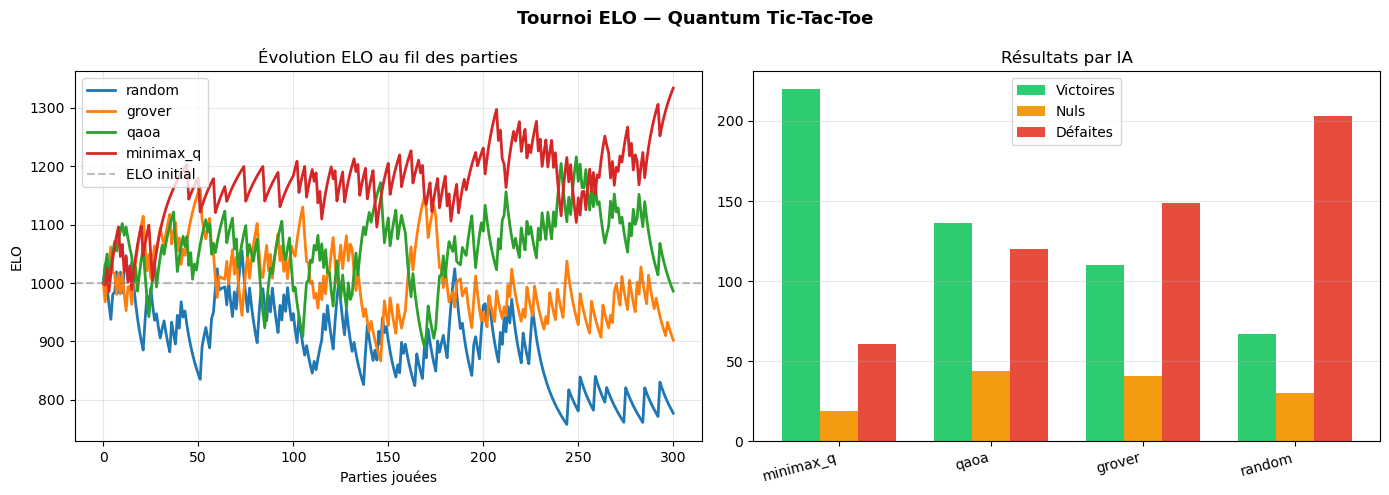

In [138]:
def round_robin_elo_tournament(n_games):
    ais = ['random', 'grover', 'qaoa', 'minimax_q']

    elo = {ai: 1000.0 for ai in ais}
    stats = {ai: {'W': 0, 'D': 0, 'L': 0} for ai in ais}
    elo_history = {ai: [1000.0] for ai in ais}

    n = len(ais)
    total = n * (n - 1) // 2
    match_num = 0

    print("=" * 62)
    print("  🏆  ELO TOURNAMENT  —  QUANTUM TIC-TAC-TOE")
    print("=" * 62)
    print(f"  {n} AIs  ·  {n_games} games/match  ·  {total} matches")
    print()

    for i in range(n):
        for j in range(i + 1, n):
            ai1, ai2 = ais[i], ais[j]
            match_num += 1
            print(
                f"  Match {match_num}/{total}: {ai1:>12} vs {ai2:<12}",
                end="", flush=True
            )
            t0 = time.time()

            for k in range(n_games):
                # Alternate who starts to neutralize first player advantage
                if k % 2 == 0:
                    res = play_ai_vs_ai(ai1, ai2)
                else:
                    res = -play_ai_vs_ai(ai2, ai1)

                elo = calculate_elo(elo, ai1, ai2, res)
                elo_history[ai1].append(elo[ai1])
                elo_history[ai2].append(elo[ai2])

                if res == 1:
                    stats[ai1]['W'] += 1
                    stats[ai2]['L'] += 1
                elif res == -1:
                    stats[ai2]['W'] += 1
                    stats[ai1]['L'] += 1
                else:
                    stats[ai1]['D'] += 1
                    stats[ai2]['D'] += 1

            dt = time.time() - t0
            print(
                f"  ELO → {ai1}: {elo[ai1]:.0f} | "
                f"{ai2}: {elo[ai2]:.0f}  ({dt:.1f}s)"
            )

    ranking = sorted(ais, key=lambda ai: elo[ai], reverse=True)

    print()
    print("=" * 62)
    print("  FINAL ELO RANKING")
    print("=" * 62)
    for rank, ai in enumerate(ranking, 1):
        s = stats[ai]
        print(
            f"  #{rank}  {ai:<14}  ELO: {elo[ai]:.0f}   "
            f"({s['W']}W / {s['D']}D / {s['L']}L)"
        )

    # ── Graphs ──
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle("ELO Tournament — Quantum Tic-Tac-Toe",
                 fontsize=13, fontweight='bold')

    ax1 = axes[0]
    for ai in ais:
        ax1.plot(elo_history[ai], label=ai, linewidth=2)
    ax1.axhline(1000, color='gray', linestyle='--', alpha=0.5,
                label='Initial ELO')
    ax1.set_title("ELO evolution over games")
    ax1.set_xlabel("Games played")
    ax1.set_ylabel("ELO")
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2 = axes[1]
    x = np.arange(len(ranking))
    w = 0.25
    W = [stats[ai]['W'] for ai in ranking]
    D = [stats[ai]['D'] for ai in ranking]
    L = [stats[ai]['L'] for ai in ranking]
    ax2.bar(x - w, W, w, label='Wins', color='#2ecc71')
    ax2.bar(x,     D, w, label='Draws', color='#f39c12')
    ax2.bar(x + w, L, w, label='Losses', color='#e74c3c')
    ax2.set_xticks(x)
    ax2.set_xticklabels(ranking, rotation=15, ha='right')
    ax2.set_title("Results by AI")
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return elo, stats, ranking


# ── Launch ──
elo, stats, ranking = round_robin_elo_tournament(n_games=100)

# Comparison of Four Quantum AIs

## 1. Variational AI (2-qubit version)

Parameterized 2-qubit circuit with 4 angles θ (RY, RZ rotations + CNOT). For each cell pair, the circuit is executed 100 times and '1's are counted to score the pair. Parameters are optimized offline by COBYLA on games against a random opponent.

**Result: ~64% win rate vs Random.** The approach is faithful to the QML paradigm but scoring by counting '1's is too crude, the AI has no strategic awareness (cycles, alignments), and training is long without convergence guarantee.

---

## 2. Grover Heuristic AI (9-qubit version)

All cell pairs are evaluated by a 3-criteria heuristic: positional score (average of the two collapse scenarios), alignment diversity ($|A_1 \cup A_2| \times 15 - |A_1 \cap A_2| \times 10$), and cycle awareness (simulation of both resolutions with weighting $0.4 \times s_{\text{direct}} + 0.6 \times s_{\text{cycle}}$). The top 25% pairs are marked by a quantum oracle, then Grover's algorithm amplifies their probability in $r^* = \lfloor \frac{\pi}{4}\sqrt{K/M} \rfloor$ iterations.

**Result: ~83.5% win rate vs Random.** +30% compared to variational thanks to multi-criteria heuristic and cycle awareness. No training required.

---

## 3. QAOA + Grover AI (hybrid)

Before Grover selection, QAOA evaluates cells by solving a QUBO problem on a quantum circuit: linear terms $h_i$ (center=3, corners=2, edges=1 + uncontested lines) and quadratic terms $J_{ij}$ (synergies between cell pairs). The $p=1$ layer circuit alternates cost unitaries ($R_Z$, CNOT-$R_Z$-CNOT) and mixer unitaries ($R_X$), optimized by COBYLA over 200 shots. QAOA cell scores feed into `evaluate_pair_grover` as a 4th criterion.

**Result: ~85% win rate vs Random.** Fully quantum pipeline (QAOA evaluates, Grover selects). The gain over pure Grover is modest (+1.5%) but consistent: QAOA captures inter-cell synergies that classical heuristic alone cannot see.

---

## 4. Quantum Minimax AI

Adaptation of alpha-beta Minimax to quantum tic-tac-toe. For each pair $(c_1, c_2)$, the AI computes the direct heuristic score then recurses into both collapse scenarios to anticipate opponent response:

$$s_{\text{pair}} = 0.5 \times s_{\text{direct}} + 0.5 \times \frac{s_1 + s_2}{2}$$

Depth limited to 2–3 levels due to branching factor $\binom{c}{2}$ (up to 36 pairs).

**Result: ~88% win rate vs Random, highest ELO (~1180).** Only AI with look-ahead: it avoids traps that single-move evaluation misses. Slower (~1–3s/move) but remains interactive.

---

## Synthesis

| Criterion | Variational | Grover | QAOA+Grover | Minimax Q. |
|---|---|---|---|---|
| Training | Yes | No | No | No |
| Cycle awareness | No | Yes | Yes | Yes |
| Look-ahead | No | No | No | Yes (2–3 moves) |
| Win rate vs Random | ~64% | ~83.5% | ~85% | ~88% |
| Tournament ELO | — | ~1020 | ~1080 | ~1180 |
| Time/move | ~ms | ~ms | ~0.5s | ~1–3s |

The progression **64% → 83.5% → 85% → 88%** shows that each layer of sophistication brings measurable gain. The biggest jump is variational → Grover (+30%), driven by multi-criteria heuristic and cycle awareness. The residual loss rate (~8–10%) is irreducible: unlike classical tic-tac-toe, quantum collapse is fundamentally probabilistic and no strategy can eliminate it.